## ANALYZING ACS TO IDENTIFY ZIP CODES PRONE TO POVERTY

In this project, we intend to analyze the American Community Survey (ACS) data to identify the zip codes that might be prone to poverty. 

The **objective** is to find the trend of poverty in the zip codes by analyzing various demographic variables through machine learning techniques and identify which zip codes fall ‘under poverty’ criteria.

## About the Data

The data has been collected from American Community Survey (ACS) (https://www.socialexplorer.com/explore-tables) which is a demographical survey program conducted by the US Census Bureau. We obtained the data from the Social Explorer website for the years spanning from 2017-2021. 


## Flow of the Project
[Data Cleaning and Preprocessing](#my-heading_1)
<br> [EDA](#Heading_2)
<br> [Clustering](#my-heading_3)
<br> [Cluster Analysis](#my-heading_4)
<br> [AR mining Preprocessing](#my-heading_5)

# Imports

In [1]:
#imports for data manipulation
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

#imports for implementing machine learning algorithm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

#imports for visualization
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
import json

warnings.filterwarnings("ignore")

%matplotlib inline

## <a id='my-heading_1'></a> Data Cleaning and Preparation

The ACS had over 30,000 ZCTA zip codes. To create an optimized model we first filtered the data for zip codes starting with 10000 to 20000 covering states of Delaware, New York, and Pennsylvania.

(Note: The model can be used for different set of zipcode analysis too) 

Next, we filtered the ACS data for relevant variables to be analysed since ACS dataset had more than two thousand variables from different categories. 


In [2]:
#uploading the dataset file with filtered variables
path = "C:\\Users\\ARU PC\\Documents\\GitHub\\DataTrimmed\\DataTrimmed\\"
dfs = {}

In [3]:
#creating a def for renaming the column names, selection the relevant columns, converting them to floats and dropping NAs

#the "def prepare_df" is created so that it can be implemented with ease on other year dataset

def prepare_df(df):
    df.rename(columns={'Geo_NAME': 'zip_code'}, inplace=True)
    df = df.loc[pd.to_numeric(df.zip_code).between(10000,20000)] # Filtering rows to limit the data we work on. Selecting group of states starting with 1
    df.set_index('zip_code', inplace=True)
    table_names = ['SE_B13004', 'SE_B18002', 'SE_A03001', 'SE_A13007', 'SE_A14028','SE_A14024_', 'SE_B12001', 'SE_A12003', 'SE_A12004', 'SE_A17005', 'SE_A17009', 'SE_A20001', 'SE_A00002','SE_A10036','SE_A18009']
    matching_columns = [col for col in df.columns if col.startswith(tuple(table_names))]
    df = df.loc[:, df.columns.isin(matching_columns)]
    df = df.astype(float)
    df = df.dropna() # Drop rows with missing values

    return df



There were many sub-levels present for each variable from which we chose the relevant ones. These variables were generated by taking proportion of the sub-group to overall population.

The **def process_columns** is created so that it can be implemented with ease on other year dataset


In [4]:
def process_columns(df):
    
    # INCOME AND POVERTY
    df['underPoverty'] = np.where(df[('SE_B13004_005')].div(df[('SE_B13004_001')]) < 0.5,1,0) 
    df = df.loc[: ,~df.columns.str.startswith('SE_B13004')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A13007_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'incomeBelowPovertyLevelProportion'] = ((df.loc[:,('SE_A13007_002')].values) /(df.loc[:,('SE_A13007_001')].values))
    df.incomeBelowPovertyLevelProportion.describe()
    df = df.loc[: ,~df.columns.str.startswith('SE_A13007')] # Drop the columns from the table after processing

    df.loc[:, 'incomePerCapita'] = df.loc[: ,df.columns.str.startswith('SE_A14024_001')].values
    df = df.loc[: ,~df.columns.str.startswith('SE_A14024')] # Drop the columns from the table after processing

    df.loc[:, 'incomeGiniIndex'] = df.loc[: ,df.columns.str.startswith('SE_A14028_001')] 
    df = df.loc[: ,~df.columns.str.startswith('SE_A14028')] # Drop the columns from the table after processing

    df.loc[:, 'popDensity'] = df.loc[:,('SE_A00002_002')].values 
    df = df.loc[: ,~df.columns.str.startswith('SE_A00002')] # Drop the columns from the table after processing
    
    #RACE
    df = df.loc[df.loc[:,('SE_A03001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'whiteMajority'] = ((df.loc[:,'SE_A03001_002'].values) / (df.loc[:,'SE_A03001_001'].values)) # If the proportion of white alone population is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A03001')] # Drop the columns from the table after processing

    #EDUCATION
    df = df.loc[df['SE_B12001_001'] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduHsOrLessProportion'] = ((df.loc[:,('SE_B12001_002')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduHsProportion'] = ((df.loc[:,('SE_B12001_003')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduBachOrBetterProportion'] = ((df.loc[:,('SE_B12001_004')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df = df.loc[: ,~df.columns.str.startswith('SE_B12001_')] # Drop the columns from the table after processing

    df.loc[:, 'eduEnrollmentProportion'] = ((df.loc[:,('SE_A12004_002')].values) / (df.loc[:,('SE_A12004_001')].values)) # If the proportion of 3yo and over enrolled in school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12004')] # Drop the columns from the table after processing

    df = df.loc[df['SE_A12003_001'] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduDropoutProportion'] = ((df.loc[:,('SE_A12003_002')].values) / (df.loc[:,('SE_A12003_001')].values)) # If the proportion of late teens dropped out from school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12003')] # Drop the columns from the table after processing

    #EMPLOYEMENT
    df = df.loc[df.loc[:,('SE_A17005_001')] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedProportion'] = ((df.loc[:,('SE_A17005_002')].values) / (df.loc[:,('SE_A17005_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17005')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A17009_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedPvtSecProportion'] = ((df.loc[:,('SE_A17009_002')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPubSecProportion'] = ((df.loc[:,('SE_A17009_003')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedSelfEmpProportion'] = ((df.loc[:,('SE_A17009_004')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPvtNonProProportion'] = ((df.loc[:,('SE_A17009_005')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedUnpaidFamProportion'] = ((df.loc[:,('SE_A17009_006')].values) / (df.loc[:,('SE_A17009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17009')] # Drop the columns from the table after processing

    # HEALTH AND HOUSING
    df = df.loc[df.loc[:,('SE_A20001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'insuredProportion'] = ((df.loc[:,('SE_A20001_003')].values) / (df.loc[:,('SE_A20001_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A20001')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:, ('SE_B18002_001')] != 0] # Remove observations with 0 to avoid error while dividing
    df.loc[:, 'housingRentMoreThan30pcProportion'] = ((df.loc[:,('SE_B18002_002')].values + df.loc[:,('SE_B18002_003')].values ) / (df.loc[:,('SE_B18002_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_B18002')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianValue'] = ((df.loc[:,('SE_A10036_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A10036_')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianGrossRent'] = ((df.loc[:,('SE_A18009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A18009')] # Drop the columns from the table after processing

    return df

    

Creating a for loop to read multiple CSV files (one for each year) and applies preparation and processing steps to each dataframe. The dataframes are stored in a dictionary 'dfs' with keys representing the dynamic variable names (df2017, df2018, etc.), allowing access to the processed dataframes later in the code

In [5]:
%%time
print("Working on data.............")
for year in range(2017,2022):
    print(f"Processing {year}")
    df_name = f'df{year}'
    filepath = path + str(year) + '_trimmed.csv'
    dfs[df_name] = pd.read_csv(filepath)
    print(f"Preparing df{year} for processing")
    dfs[df_name] = prepare_df(dfs[df_name])
    print(f"Processing df{year} columns")
    dfs[df_name] = process_columns(dfs[df_name])

Working on data.............
Processing 2017
Preparing df2017 for processing
Processing df2017 columns
Processing 2018
Preparing df2018 for processing
Processing df2018 columns
Processing 2019
Preparing df2019 for processing
Processing df2019 columns
Processing 2020
Preparing df2020 for processing
Processing df2020 columns
Processing 2021
Preparing df2021 for processing
Processing df2021 columns
Wall time: 41.7 s


In [6]:
dfs_agg = dfs.copy()

## <a id='Heading_2'></a> Exploratory Data Analysis (EDA)


### Info of dataframe

In [7]:
%%time
for key, df in dfs.items():
    print(f"=== Info for {key} ===")
    print("=======================")
    print(df.info())    

=== Info for df2017 ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2887 entries, 10001 to 19979
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   underPoverty                       2887 non-null   int32  
 1   incomeBelowPovertyLevelProportion  2887 non-null   float64
 2   incomePerCapita                    2887 non-null   float64
 3   incomeGiniIndex                    2887 non-null   float64
 4   popDensity                         2887 non-null   float64
 5   whiteMajority                      2887 non-null   float64
 6   eduHsOrLessProportion              2887 non-null   float64
 7   eduHsProportion                    2887 non-null   float64
 8   eduBachOrBetterProportion          2887 non-null   float64
 9   eduEnrollmentProportion            2887 non-null   float64
 10  eduDropoutProportion               2887 non-null   float64
 11  employedProportion         

### Describe
Data summary for numerical variables for different years

In [8]:
%%time
for key, df in dfs.items():
    print(f"=== Describe for {key} ===")
    print("============================")
    display(df.describe())    


=== Describe for df2017 ===


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
count,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,...,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2.887000e+03,2887.000000
mean,0.062695,0.110236,31806.040873,0.419691,4033.800947,0.867541,0.107979,0.625337,0.266684,0.226644,...,0.937065,0.654975,0.144386,0.096584,0.101942,0.002113,0.928316,0.408847,2.170859e+05,950.688950
std,0.242455,0.068827,14131.060441,0.056284,13545.365055,0.189170,0.065779,0.139577,0.159757,0.062902,...,0.035178,0.093326,0.067587,0.051525,0.045492,0.005762,0.052875,0.152616,1.992003e+05,403.966092
min,0.000000,0.000000,4284.000000,0.185600,0.789848,0.021461,0.000000,0.080946,0.000000,0.000000,...,0.700344,0.273684,0.000000,0.000000,0.000000,0.000000,0.366816,0.000000,2.230000e+04,234.000000
25%,0.000000,0.062459,24210.500000,0.383850,67.779115,0.844740,0.063071,0.557812,0.153152,0.191800,...,0.922913,0.603405,0.096608,0.063177,0.073159,0.000000,0.913487,0.316304,1.066500e+05,688.000000
50%,0.000000,0.096335,28112.000000,0.414500,256.493800,0.946746,0.096033,0.660330,0.220880,0.222086,...,0.943403,0.665854,0.133292,0.086957,0.096285,0.000000,0.939296,0.415188,1.544000e+05,821.000000
75%,0.000000,0.138707,35076.000000,0.451350,1727.167500,0.977980,0.135182,0.723109,0.337357,0.254502,...,0.959629,0.717531,0.180583,0.119232,0.124543,0.002008,0.958962,0.504704,2.390000e+05,1087.500000
max,1.000000,0.550931,153897.000000,0.666300,159438.900000,1.000000,0.535537,0.981221,0.904940,0.920959,...,1.000000,1.000000,0.546512,0.469663,0.411058,0.123853,1.000000,1.000000,2.000001e+06,3501.000000


=== Describe for df2018 ===


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
count,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,...,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2882.000000,2.882000e+03,2882.000000
mean,0.058987,0.108513,33149.148855,0.420437,3989.496154,0.865820,0.104780,0.622649,0.272572,0.224040,...,0.943871,0.655063,0.143525,0.096985,0.102206,0.002221,0.937934,0.404453,2.230767e+05,978.712353
std,0.235641,0.068869,14654.195627,0.057318,13343.555170,0.189781,0.064802,0.140725,0.160920,0.062560,...,0.032340,0.092718,0.066799,0.051924,0.045332,0.006411,0.051350,0.152075,2.047102e+05,419.524038
min,0.000000,0.000000,4363.000000,0.148100,0.937378,0.017646,0.000000,0.084806,0.000000,0.000000,...,0.724719,0.230769,0.000000,0.000000,0.000000,0.000000,0.381228,0.000000,2.600000e+04,289.000000
25%,0.000000,0.060744,25158.000000,0.384500,67.576835,0.843025,0.061118,0.551908,0.156296,0.190690,...,0.930123,0.602629,0.096187,0.063260,0.073863,0.000000,0.925304,0.313686,1.090000e+05,702.000000
50%,0.000000,0.095013,29307.500000,0.416100,259.773100,0.944096,0.092945,0.659478,0.227601,0.220005,...,0.949959,0.665298,0.133103,0.086382,0.096471,0.000000,0.948882,0.413411,1.568000e+05,841.000000
75%,0.000000,0.138002,36381.500000,0.450975,1727.251750,0.977290,0.131633,0.721097,0.349211,0.251602,...,0.964779,0.717955,0.179972,0.119201,0.124650,0.002094,0.966641,0.501164,2.449500e+05,1120.000000
max,1.000000,0.517228,147547.000000,0.744000,152562.200000,1.000000,0.631382,0.941799,0.904201,0.918690,...,1.000000,0.944853,0.551440,0.455285,0.418719,0.148936,1.000000,1.000000,2.000001e+06,3501.000000


=== Describe for df2019 ===


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
count,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,...,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2.856000e+03,2856.000000
mean,0.059874,0.105943,34517.297619,0.421073,3996.209031,0.864107,0.102227,0.619412,0.278361,0.221662,...,0.948727,0.653154,0.144876,0.096139,0.103567,0.002264,0.943066,0.400008,2.303800e+05,1001.792367
std,0.237295,0.067413,15373.485946,0.056863,13271.132963,0.189863,0.064064,0.143231,0.162731,0.062408,...,0.031007,0.092962,0.067670,0.050625,0.045999,0.006313,0.051905,0.152443,2.127244e+05,434.224649
min,0.000000,0.000000,4744.000000,0.170400,0.851130,0.024178,0.000000,0.070849,0.000000,0.000000,...,0.648963,0.191489,0.000000,0.000000,0.000000,0.000000,0.396632,0.000000,2.720000e+04,323.000000
25%,0.000000,0.059402,26022.000000,0.385900,67.234912,0.841947,0.058542,0.546006,0.160146,0.187330,...,0.936530,0.602458,0.096885,0.063173,0.074605,0.000000,0.932719,0.308070,1.130000e+05,718.000000
50%,0.000000,0.092681,30583.000000,0.416400,257.172300,0.942168,0.089177,0.653468,0.234329,0.217606,...,0.954567,0.662736,0.134891,0.086921,0.097302,0.000000,0.954917,0.407407,1.600000e+05,856.000000
75%,0.000000,0.134132,37985.250000,0.453050,1756.211500,0.976889,0.129793,0.720817,0.356162,0.250218,...,0.968162,0.714632,0.180956,0.117050,0.125896,0.002323,0.971130,0.498136,2.524000e+05,1138.000000
max,1.000000,0.609756,152846.000000,0.729100,149289.800000,1.000000,0.503417,1.000000,0.918576,0.908617,...,1.000000,0.951691,0.575064,0.439320,0.561856,0.127273,1.000000,1.000000,2.000001e+06,3501.000000


=== Describe for df2020 ===


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,4.100000e+01,41.000000
mean,0.097561,0.137187,88079.219512,0.536961,78824.647610,0.565206,0.103755,0.239018,0.657228,0.192781,...,0.943552,0.670007,0.088816,0.116169,0.123495,0.001512,0.956326,0.415253,1.005032e+06,2088.341463
std,0.300406,0.076368,44251.043968,0.054890,32052.370236,0.229258,0.095502,0.125484,0.209808,0.059076,...,0.030417,0.060737,0.043878,0.040286,0.041966,0.002566,0.025733,0.068483,4.767211e+05,746.583706
min,0.000000,0.016632,26109.000000,0.380500,6168.662000,0.121969,0.000000,0.055536,0.289622,0.067281,...,0.868605,0.529861,0.030567,0.049365,0.031463,0.000000,0.886050,0.293333,3.750000e+05,882.000000
25%,0.000000,0.080492,36875.000000,0.497700,55504.800000,0.330641,0.023835,0.146194,0.422333,0.154203,...,0.930832,0.646681,0.056131,0.083652,0.089256,0.000000,0.937417,0.369118,6.513000e+05,1417.000000
50%,0.000000,0.115537,101031.000000,0.549200,76061.160000,0.634540,0.073832,0.203680,0.736736,0.198624,...,0.954636,0.670868,0.077519,0.112442,0.123801,0.000656,0.965131,0.415786,9.413000e+05,2184.000000
75%,0.000000,0.195664,123969.000000,0.568500,98371.770000,0.745203,0.170335,0.368416,0.825608,0.234752,...,0.961427,0.696960,0.113449,0.145330,0.147639,0.001762,0.973560,0.450386,1.236900e+06,2524.000000
max,1.000000,0.333875,182463.000000,0.626700,153099.800000,0.876131,0.338570,0.511558,0.939979,0.364898,...,0.985880,0.825595,0.213587,0.208350,0.246923,0.013785,0.998226,0.544919,2.000001e+06,3501.000000


=== Describe for df2021 ===


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
count,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,...,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2762.000000,2.762000e+03,2762.000000
mean,0.051412,0.102493,37852.136495,0.421892,4194.044220,0.842032,0.096271,0.610639,0.293090,0.218905,...,0.945659,0.643166,0.149205,0.096581,0.108756,0.002291,0.944078,0.391692,2.482243e+05,1073.119841
std,0.220877,0.063519,17263.249927,0.058448,13579.232200,0.196410,0.063522,0.148644,0.166977,0.063484,...,0.033943,0.094417,0.069294,0.051785,0.050685,0.006065,0.054047,0.158037,2.244529e+05,472.617585
min,0.000000,0.000000,5116.000000,0.156100,0.834195,0.019053,0.000000,0.030905,0.012195,0.000000,...,0.672566,0.177778,0.000000,0.000000,0.000000,0.000000,0.393746,0.000000,9.999000e+03,379.000000
25%,0.000000,0.058270,28145.750000,0.384850,66.830888,0.802563,0.053964,0.536000,0.172751,0.183830,...,0.931652,0.591457,0.099606,0.062881,0.077732,0.000000,0.933320,0.289294,1.219250e+05,754.000000
50%,0.000000,0.089018,33431.500000,0.417300,271.956550,0.921079,0.082997,0.644533,0.247534,0.215234,...,0.951351,0.651538,0.140871,0.086922,0.102559,0.000000,0.956894,0.400691,1.708000e+05,921.000000
75%,0.000000,0.130092,41647.750000,0.455200,1854.641000,0.964396,0.119928,0.715765,0.374775,0.248454,...,0.967480,0.703504,0.187346,0.118828,0.132468,0.002183,0.973802,0.495768,2.732750e+05,1232.750000
max,1.000000,0.473985,180412.000000,0.657200,151475.800000,1.000000,0.528090,0.930636,0.965508,0.876300,...,1.000000,0.965035,0.655556,0.444238,0.534653,0.115092,1.000000,1.000000,2.000001e+06,3501.000000


Wall time: 359 ms


### Univariate Analysis

In [9]:
columnNames = dfs['df2017'].columns.values

Description of columns for df2017
underPoverty
----------------------------------------------------------------------------
count    2887.000000
mean        0.062695
std         0.242455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


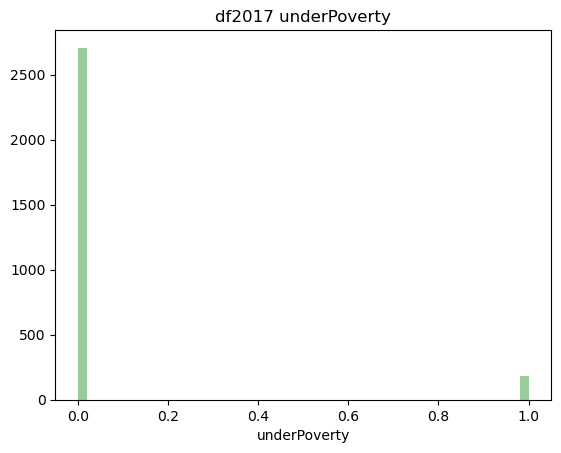

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.110236
std         0.068827
min         0.000000
25%         0.062459
50%         0.096335
75%         0.138707
max         0.550931
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


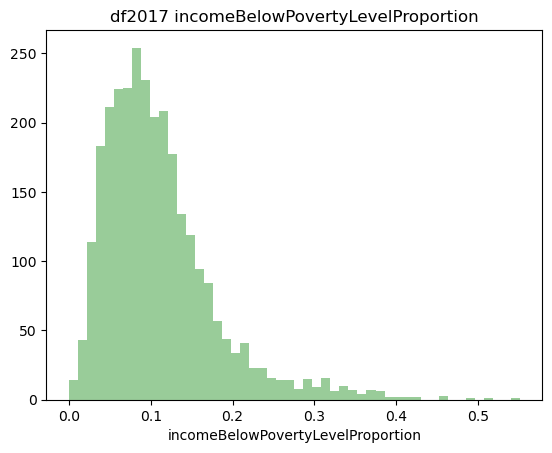

incomePerCapita
----------------------------------------------------------------------------
count      2887.000000
mean      31806.040873
std       14131.060441
min        4284.000000
25%       24210.500000
50%       28112.000000
75%       35076.000000
max      153897.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


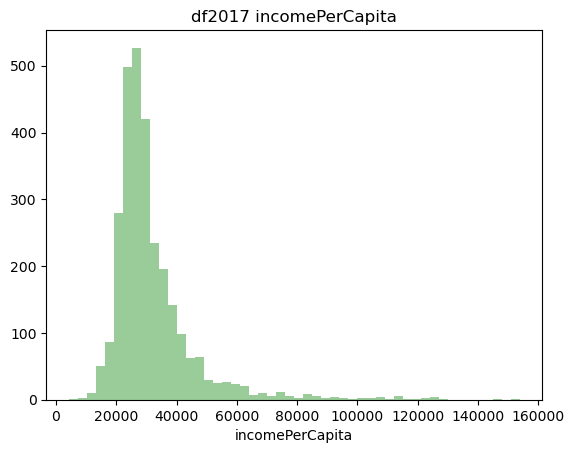

incomeGiniIndex
----------------------------------------------------------------------------
count    2887.000000
mean        0.419691
std         0.056284
min         0.185600
25%         0.383850
50%         0.414500
75%         0.451350
max         0.666300
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


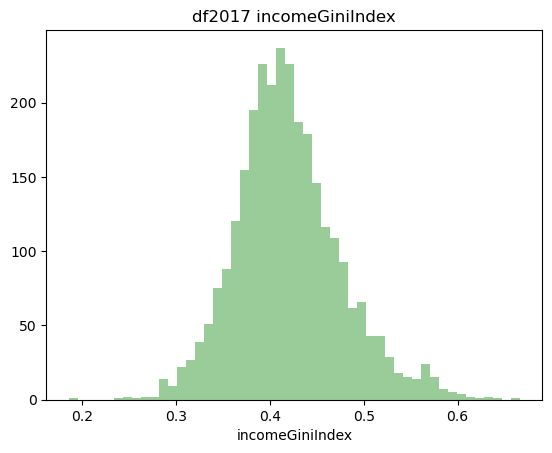

popDensity
----------------------------------------------------------------------------
count      2887.000000
mean       4033.800947
std       13545.365055
min           0.789848
25%          67.779115
50%         256.493800
75%        1727.167500
max      159438.900000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


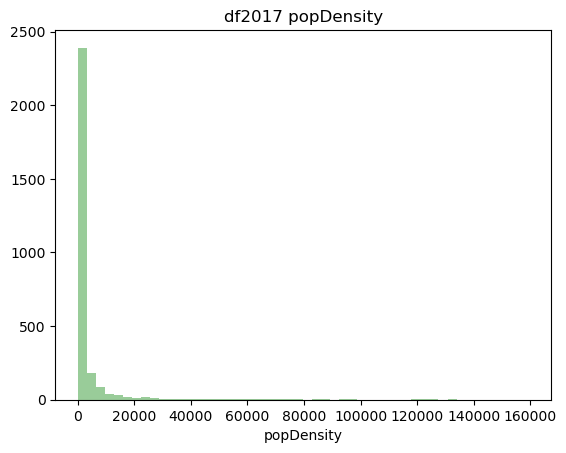

whiteMajority
----------------------------------------------------------------------------
count    2887.000000
mean        0.867541
std         0.189170
min         0.021461
25%         0.844740
50%         0.946746
75%         0.977980
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


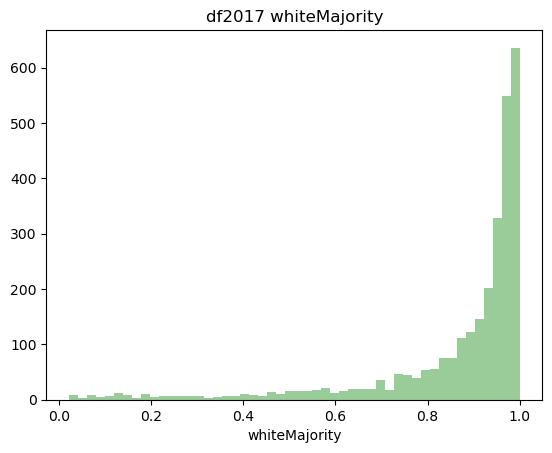

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.107979
std         0.065779
min         0.000000
25%         0.063071
50%         0.096033
75%         0.135182
max         0.535537
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


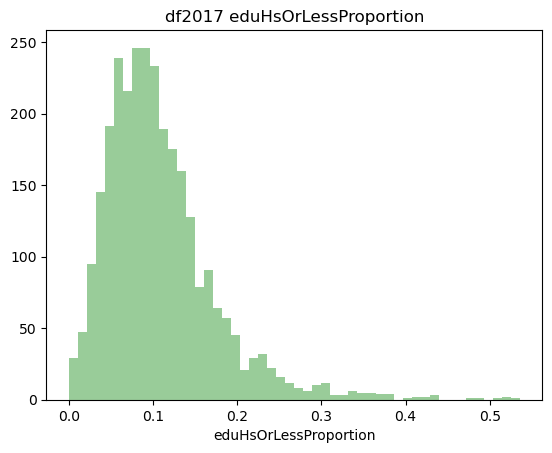

eduHsProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.625337
std         0.139577
min         0.080946
25%         0.557812
50%         0.660330
75%         0.723109
max         0.981221
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


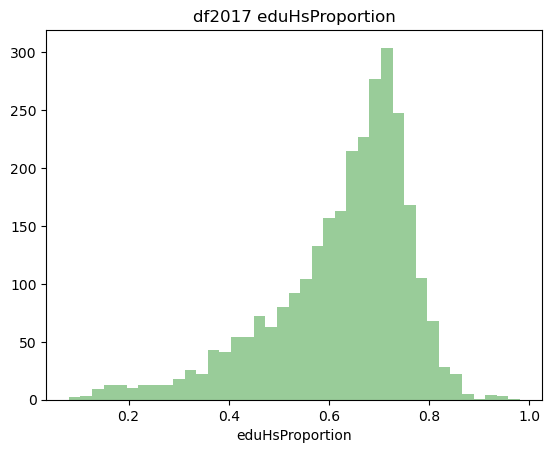

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.266684
std         0.159757
min         0.000000
25%         0.153152
50%         0.220880
75%         0.337357
max         0.904940
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


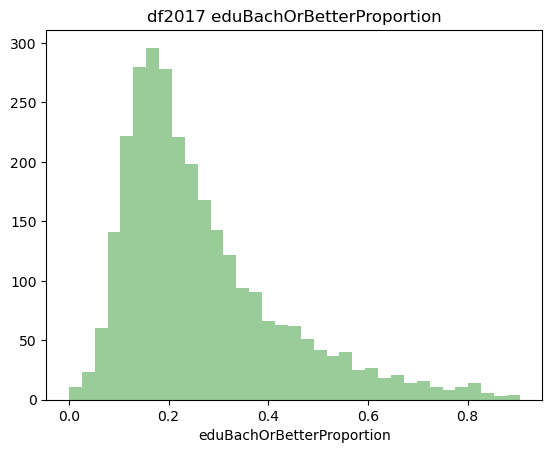

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.226644
std         0.062902
min         0.000000
25%         0.191800
50%         0.222086
75%         0.254502
max         0.920959
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


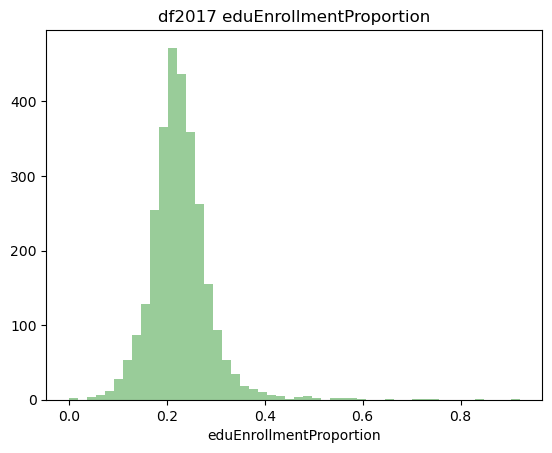

eduDropoutProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.049455
std         0.095458
min         0.000000
25%         0.000000
50%         0.013118
75%         0.057127
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


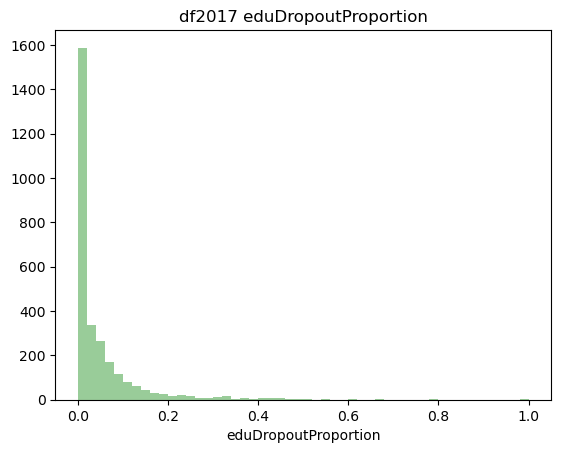

employedProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.937065
std         0.035178
min         0.700344
25%         0.922913
50%         0.943403
75%         0.959629
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


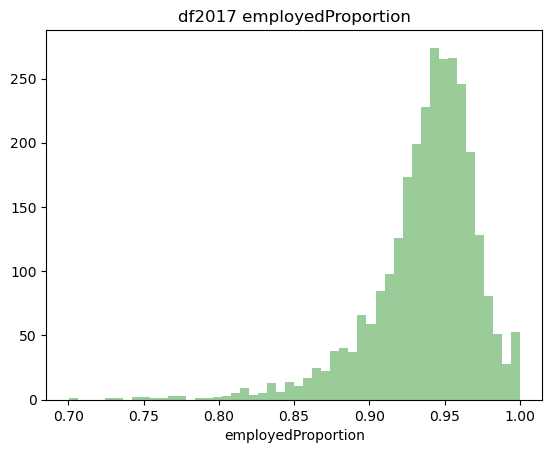

employedPvtSecProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.654975
std         0.093326
min         0.273684
25%         0.603405
50%         0.665854
75%         0.717531
max         1.000000
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


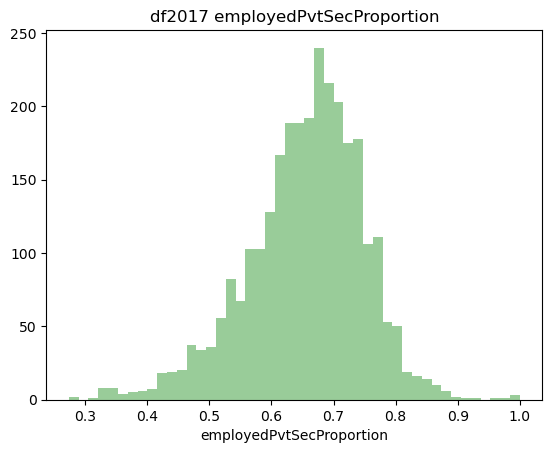

employedPubSecProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.144386
std         0.067587
min         0.000000
25%         0.096608
50%         0.133292
75%         0.180583
max         0.546512
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


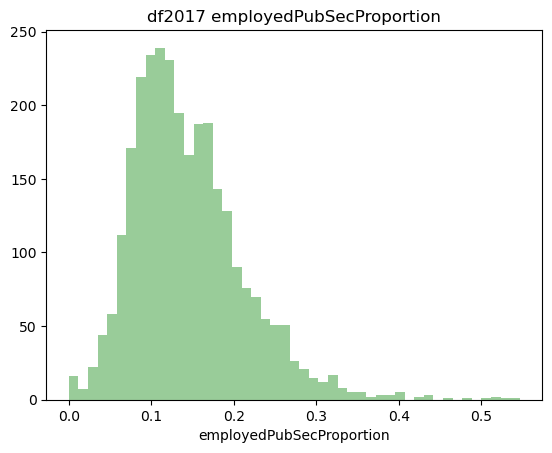

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.096584
std         0.051525
min         0.000000
25%         0.063177
50%         0.086957
75%         0.119232
max         0.469663
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


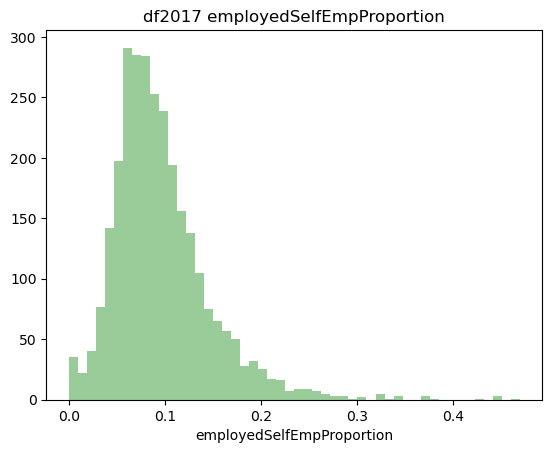

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.101942
std         0.045492
min         0.000000
25%         0.073159
50%         0.096285
75%         0.124543
max         0.411058
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


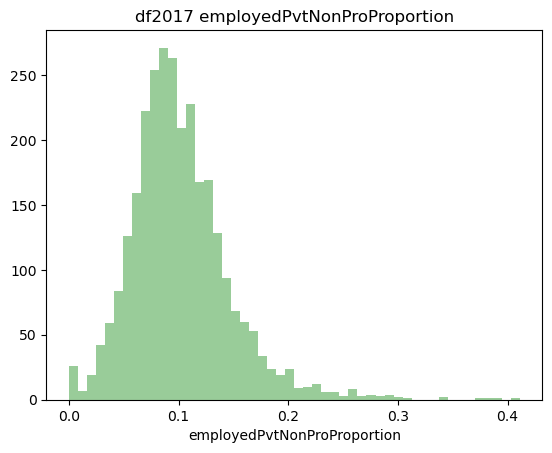

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.002113
std         0.005762
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002008
max         0.123853
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


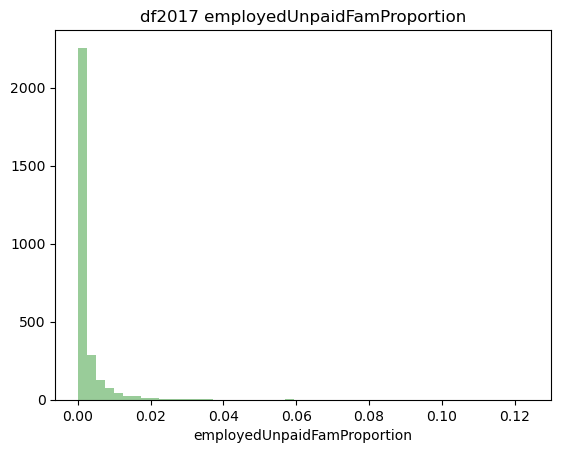

insuredProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.928316
std         0.052875
min         0.366816
25%         0.913487
50%         0.939296
75%         0.958962
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


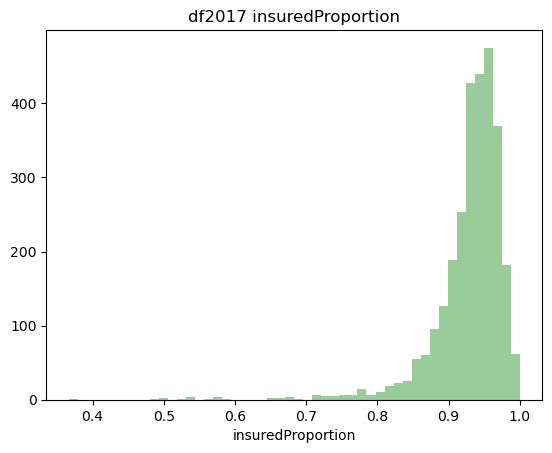

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2887.000000
mean        0.408847
std         0.152616
min         0.000000
25%         0.316304
50%         0.415188
75%         0.504704
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


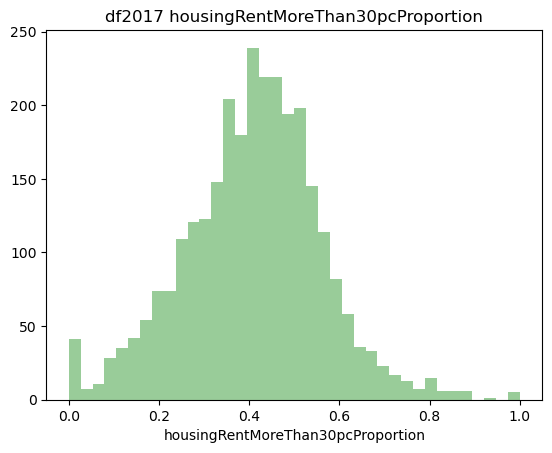

housingMedianValue
----------------------------------------------------------------------------
count    2.887000e+03
mean     2.170859e+05
std      1.992003e+05
min      2.230000e+04
25%      1.066500e+05
50%      1.544000e+05
75%      2.390000e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


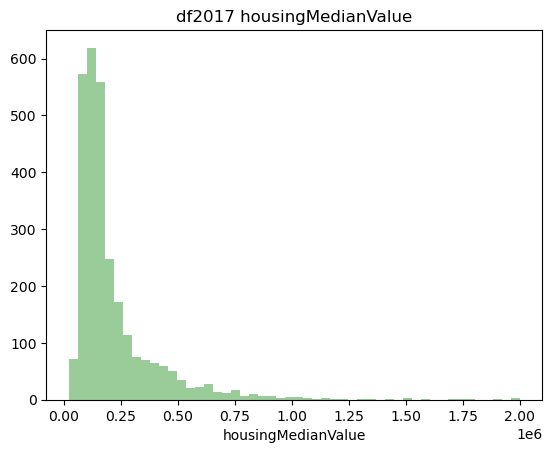

housingMedianGrossRent
----------------------------------------------------------------------------
count    2887.000000
mean      950.688950
std       403.966092
min       234.000000
25%       688.000000
50%       821.000000
75%      1087.500000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


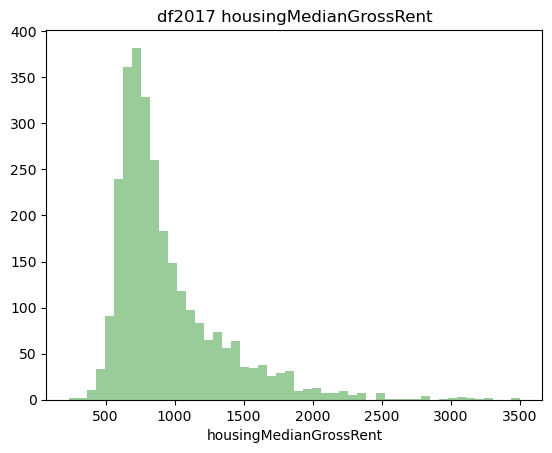

Description of columns for df2018
underPoverty
----------------------------------------------------------------------------
count    2882.000000
mean        0.058987
std         0.235641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


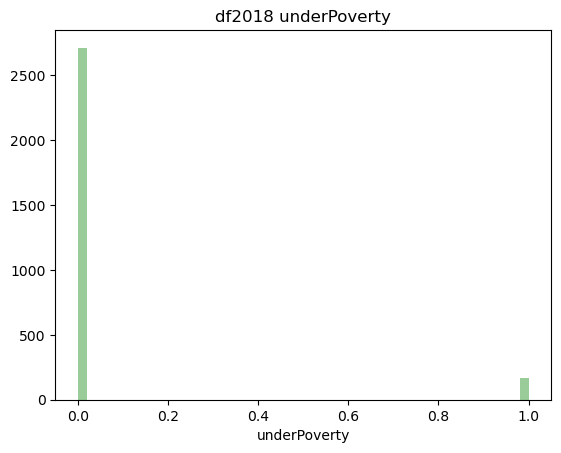

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.108513
std         0.068869
min         0.000000
25%         0.060744
50%         0.095013
75%         0.138002
max         0.517228
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


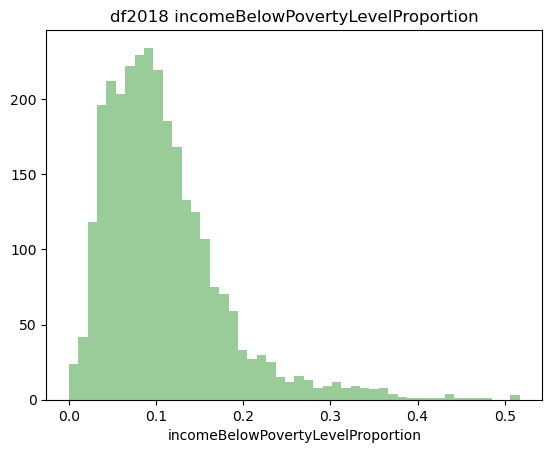

incomePerCapita
----------------------------------------------------------------------------
count      2882.000000
mean      33149.148855
std       14654.195627
min        4363.000000
25%       25158.000000
50%       29307.500000
75%       36381.500000
max      147547.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


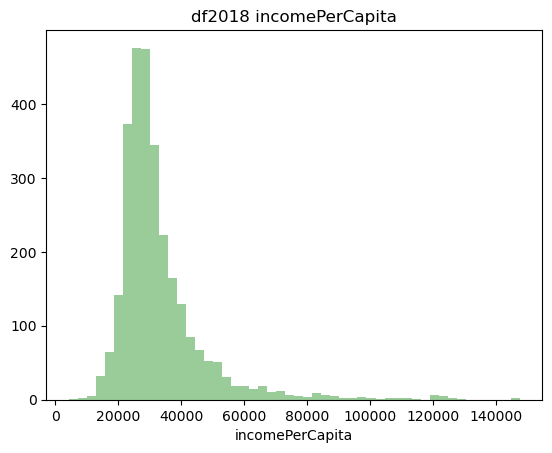

incomeGiniIndex
----------------------------------------------------------------------------
count    2882.000000
mean        0.420437
std         0.057318
min         0.148100
25%         0.384500
50%         0.416100
75%         0.450975
max         0.744000
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


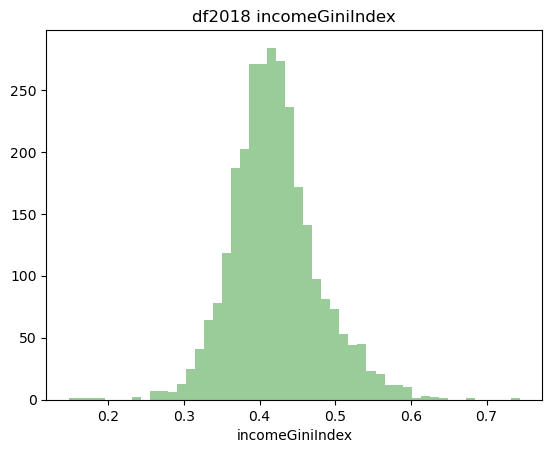

popDensity
----------------------------------------------------------------------------
count      2882.000000
mean       3989.496154
std       13343.555170
min           0.937378
25%          67.576835
50%         259.773100
75%        1727.251750
max      152562.200000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


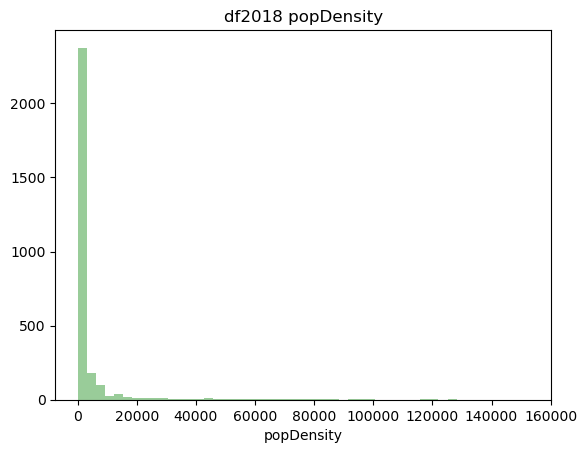

whiteMajority
----------------------------------------------------------------------------
count    2882.000000
mean        0.865820
std         0.189781
min         0.017646
25%         0.843025
50%         0.944096
75%         0.977290
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


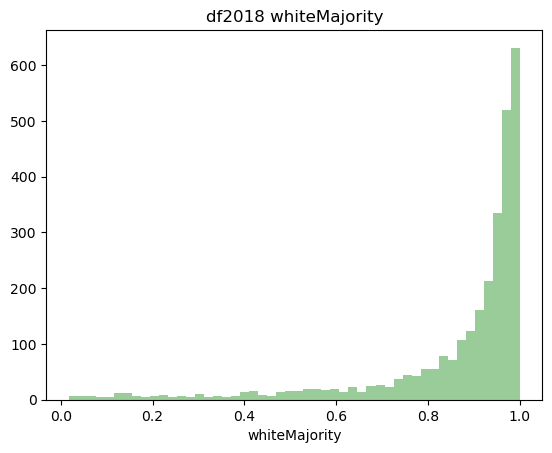

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.104780
std         0.064802
min         0.000000
25%         0.061118
50%         0.092945
75%         0.131633
max         0.631382
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


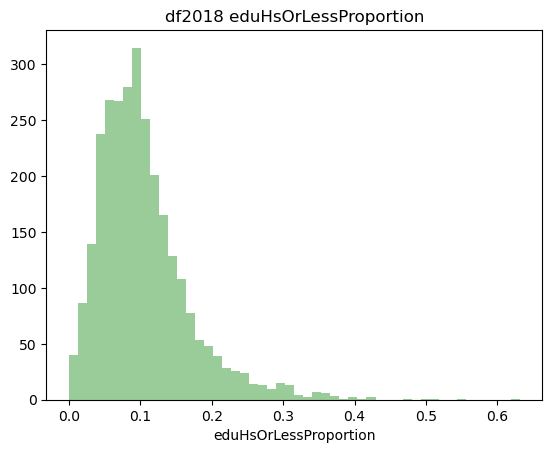

eduHsProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.622649
std         0.140725
min         0.084806
25%         0.551908
50%         0.659478
75%         0.721097
max         0.941799
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


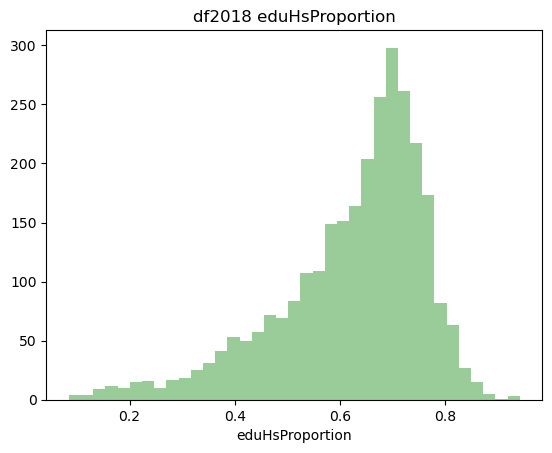

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.272572
std         0.160920
min         0.000000
25%         0.156296
50%         0.227601
75%         0.349211
max         0.904201
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


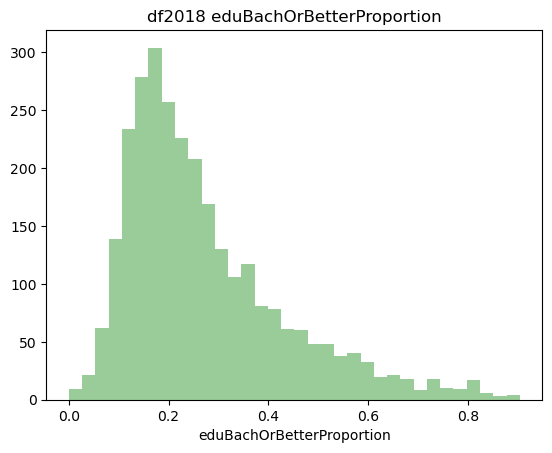

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.224040
std         0.062560
min         0.000000
25%         0.190690
50%         0.220005
75%         0.251602
max         0.918690
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


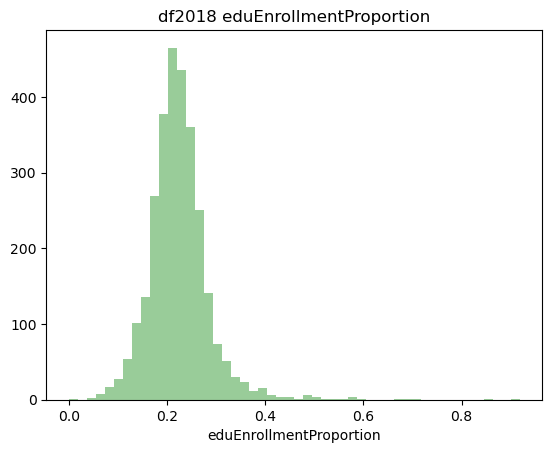

eduDropoutProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.050454
std         0.098145
min         0.000000
25%         0.000000
50%         0.012549
75%         0.058224
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


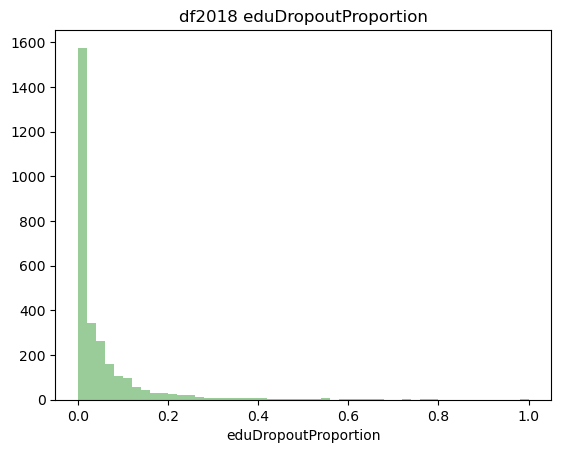

employedProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.943871
std         0.032340
min         0.724719
25%         0.930123
50%         0.949959
75%         0.964779
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


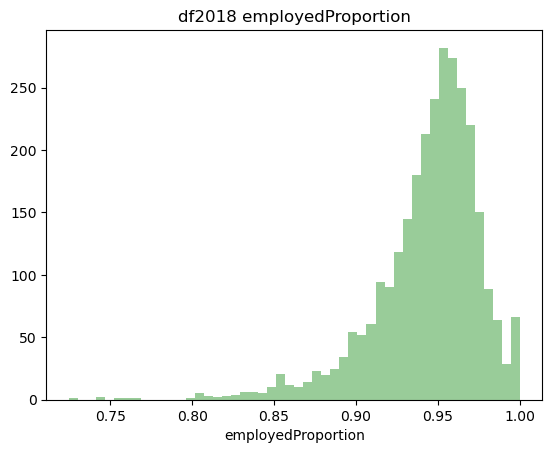

employedPvtSecProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.655063
std         0.092718
min         0.230769
25%         0.602629
50%         0.665298
75%         0.717955
max         0.944853
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


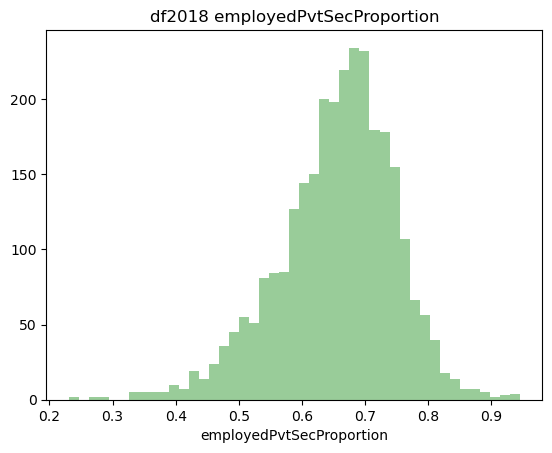

employedPubSecProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.143525
std         0.066799
min         0.000000
25%         0.096187
50%         0.133103
75%         0.179972
max         0.551440
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


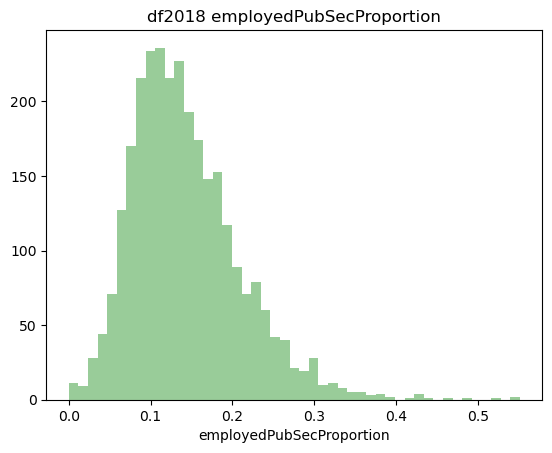

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.096985
std         0.051924
min         0.000000
25%         0.063260
50%         0.086382
75%         0.119201
max         0.455285
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


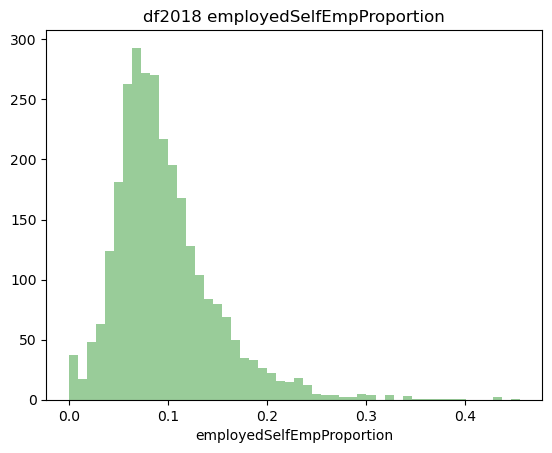

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.102206
std         0.045332
min         0.000000
25%         0.073863
50%         0.096471
75%         0.124650
max         0.418719
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


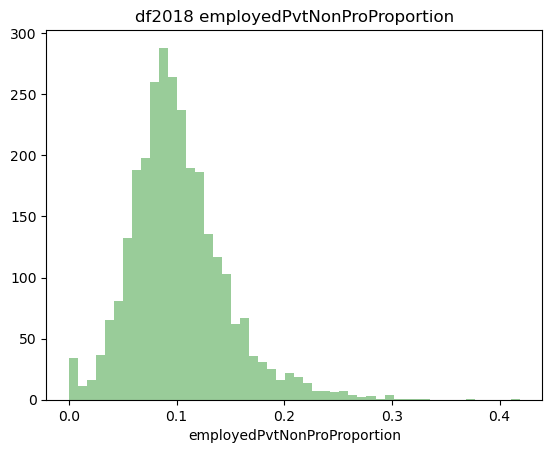

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.002221
std         0.006411
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002094
max         0.148936
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


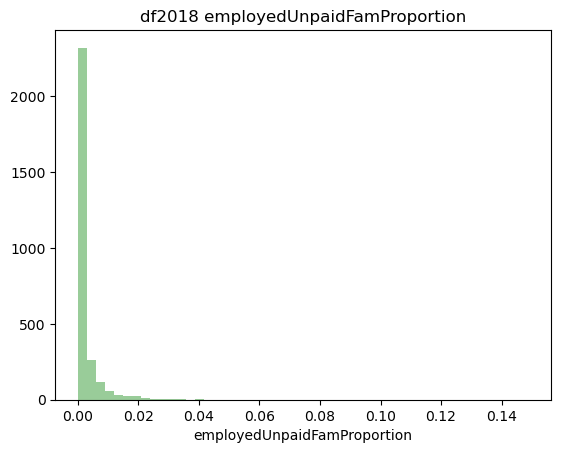

insuredProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.937934
std         0.051350
min         0.381228
25%         0.925304
50%         0.948882
75%         0.966641
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


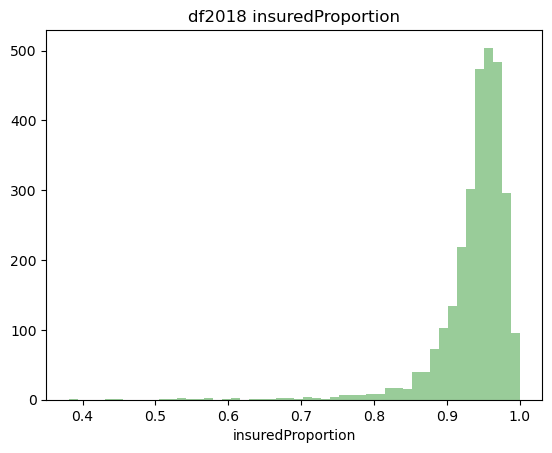

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2882.000000
mean        0.404453
std         0.152075
min         0.000000
25%         0.313686
50%         0.413411
75%         0.501164
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


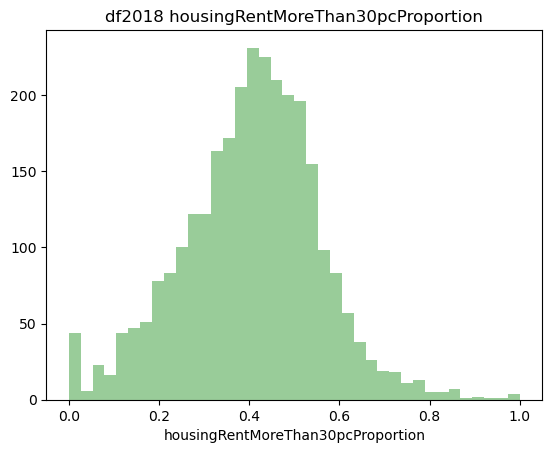

housingMedianValue
----------------------------------------------------------------------------
count    2.882000e+03
mean     2.230767e+05
std      2.047102e+05
min      2.600000e+04
25%      1.090000e+05
50%      1.568000e+05
75%      2.449500e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


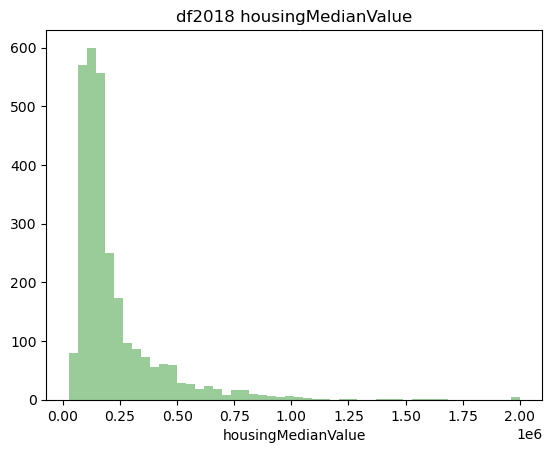

housingMedianGrossRent
----------------------------------------------------------------------------
count    2882.000000
mean      978.712353
std       419.524038
min       289.000000
25%       702.000000
50%       841.000000
75%      1120.000000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


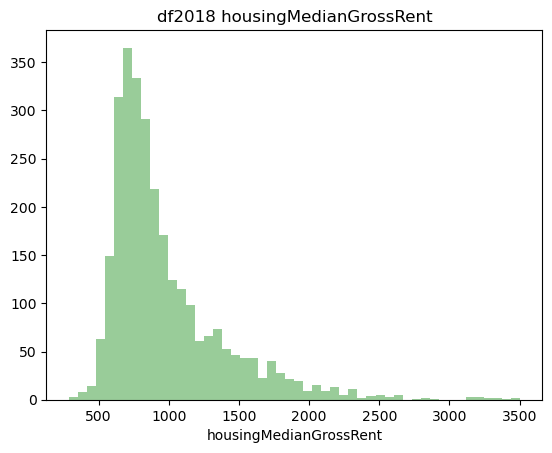

Description of columns for df2019
underPoverty
----------------------------------------------------------------------------
count    2856.000000
mean        0.059874
std         0.237295
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


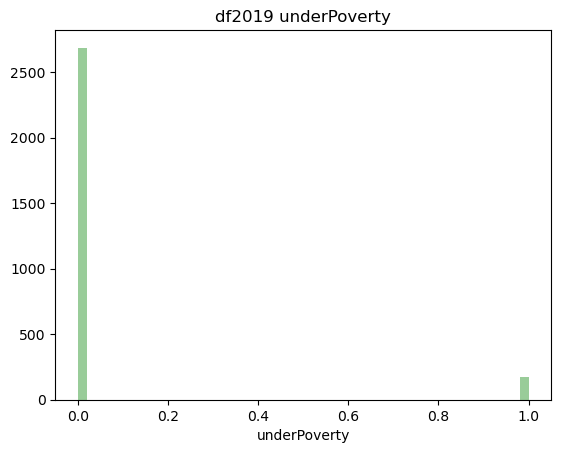

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.105943
std         0.067413
min         0.000000
25%         0.059402
50%         0.092681
75%         0.134132
max         0.609756
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


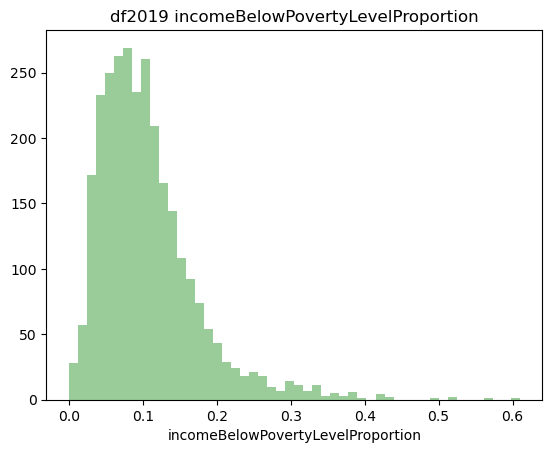

incomePerCapita
----------------------------------------------------------------------------
count      2856.000000
mean      34517.297619
std       15373.485946
min        4744.000000
25%       26022.000000
50%       30583.000000
75%       37985.250000
max      152846.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


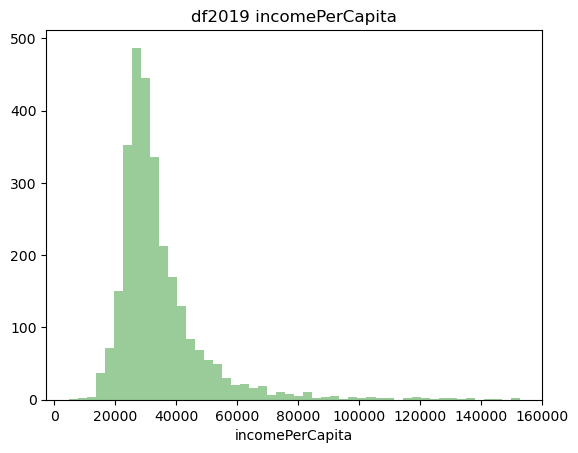

incomeGiniIndex
----------------------------------------------------------------------------
count    2856.000000
mean        0.421073
std         0.056863
min         0.170400
25%         0.385900
50%         0.416400
75%         0.453050
max         0.729100
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


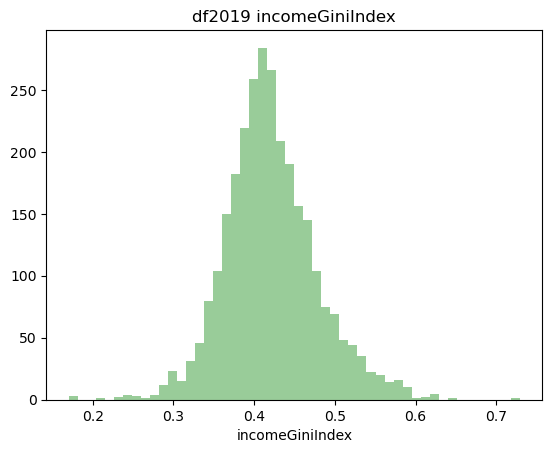

popDensity
----------------------------------------------------------------------------
count      2856.000000
mean       3996.209031
std       13271.132963
min           0.851130
25%          67.234912
50%         257.172300
75%        1756.211500
max      149289.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


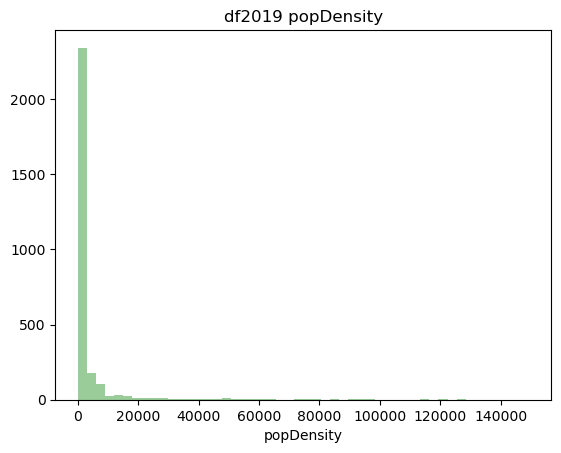

whiteMajority
----------------------------------------------------------------------------
count    2856.000000
mean        0.864107
std         0.189863
min         0.024178
25%         0.841947
50%         0.942168
75%         0.976889
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


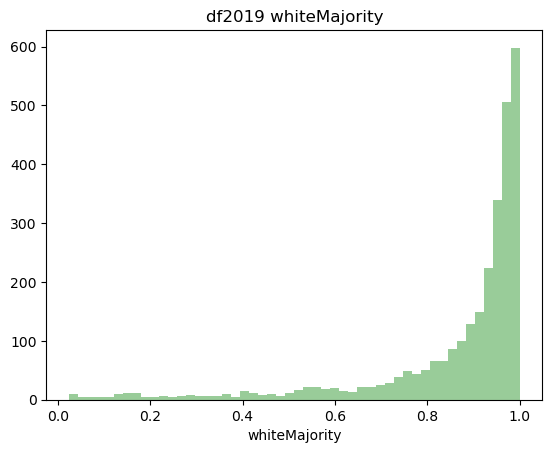

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.102227
std         0.064064
min         0.000000
25%         0.058542
50%         0.089177
75%         0.129793
max         0.503417
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


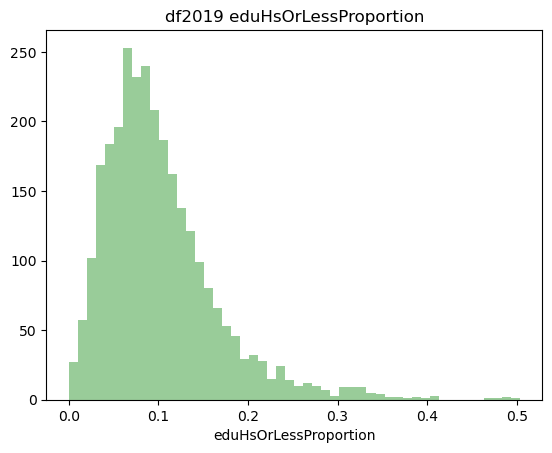

eduHsProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.619412
std         0.143231
min         0.070849
25%         0.546006
50%         0.653468
75%         0.720817
max         1.000000
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


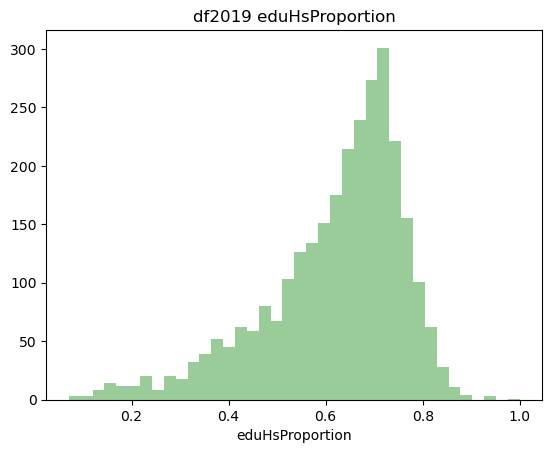

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.278361
std         0.162731
min         0.000000
25%         0.160146
50%         0.234329
75%         0.356162
max         0.918576
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


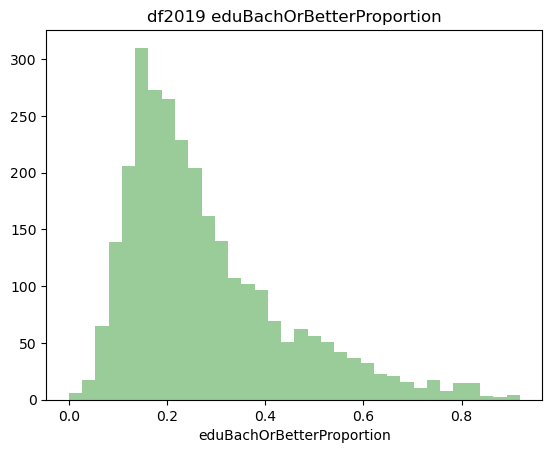

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.221662
std         0.062408
min         0.000000
25%         0.187330
50%         0.217606
75%         0.250218
max         0.908617
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


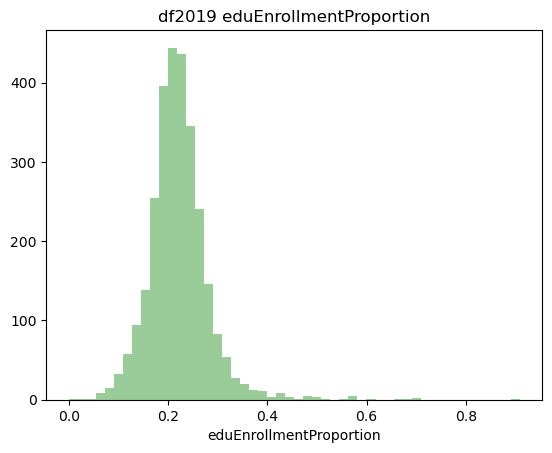

eduDropoutProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.051578
std         0.100601
min         0.000000
25%         0.000000
50%         0.011668
75%         0.059148
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


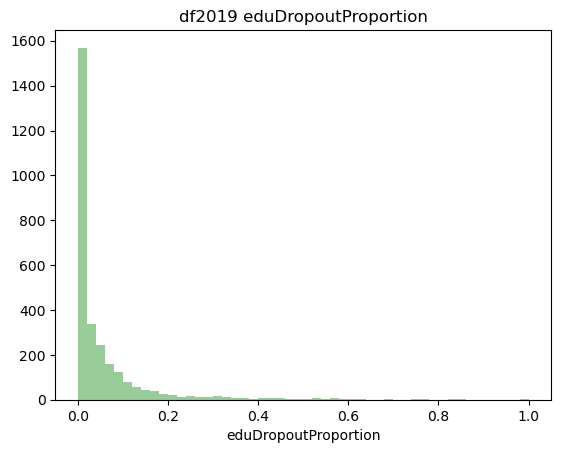

employedProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.948727
std         0.031007
min         0.648963
25%         0.936530
50%         0.954567
75%         0.968162
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


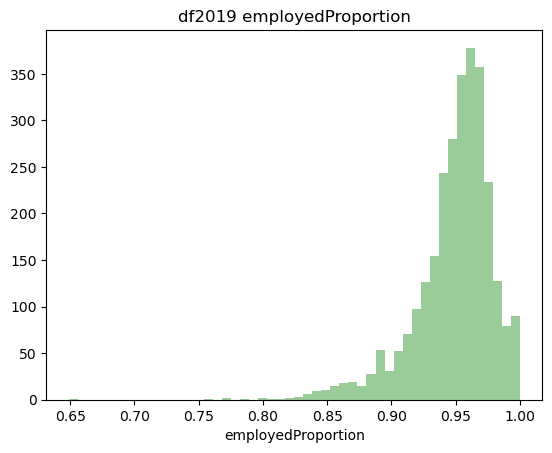

employedPvtSecProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.653154
std         0.092962
min         0.191489
25%         0.602458
50%         0.662736
75%         0.714632
max         0.951691
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


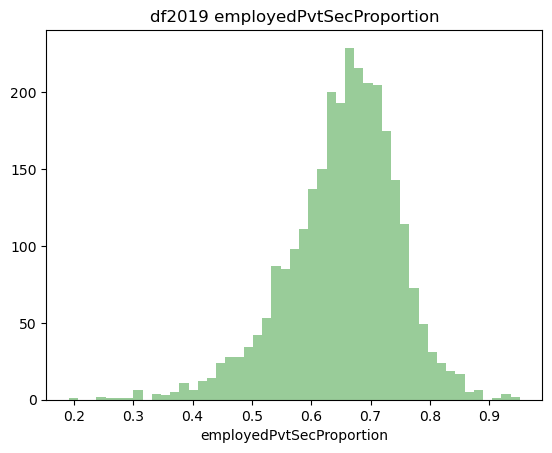

employedPubSecProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.144876
std         0.067670
min         0.000000
25%         0.096885
50%         0.134891
75%         0.180956
max         0.575064
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


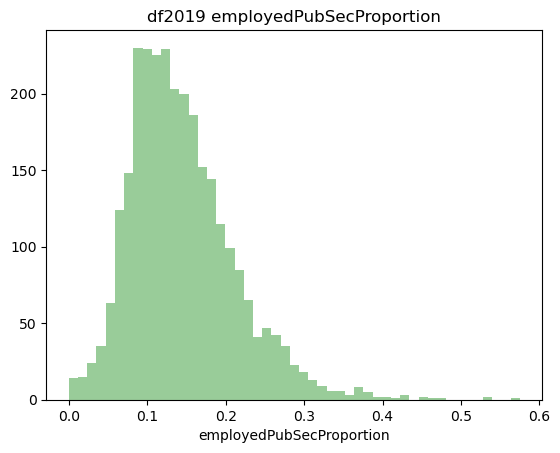

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.096139
std         0.050625
min         0.000000
25%         0.063173
50%         0.086921
75%         0.117050
max         0.439320
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


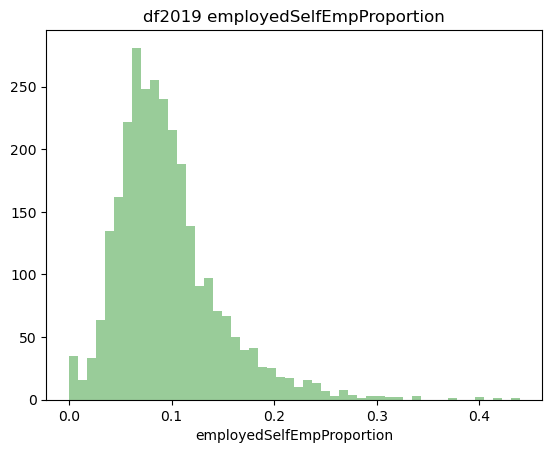

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.103567
std         0.045999
min         0.000000
25%         0.074605
50%         0.097302
75%         0.125896
max         0.561856
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


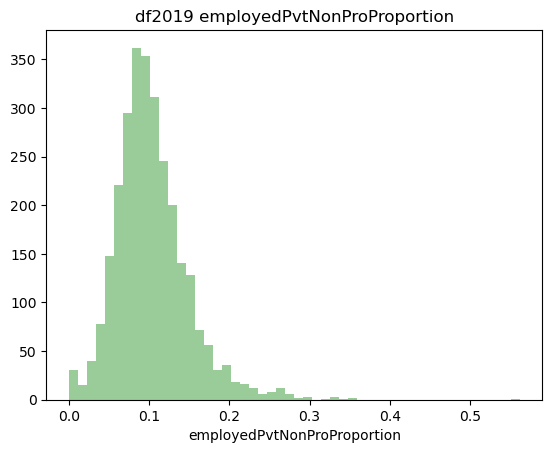

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.002264
std         0.006313
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002323
max         0.127273
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


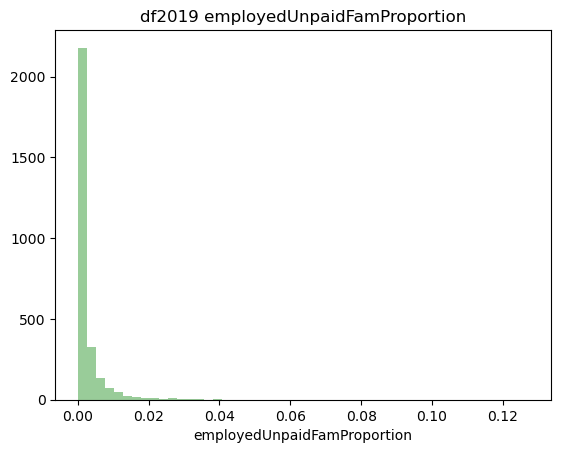

insuredProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.943066
std         0.051905
min         0.396632
25%         0.932719
50%         0.954917
75%         0.971130
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


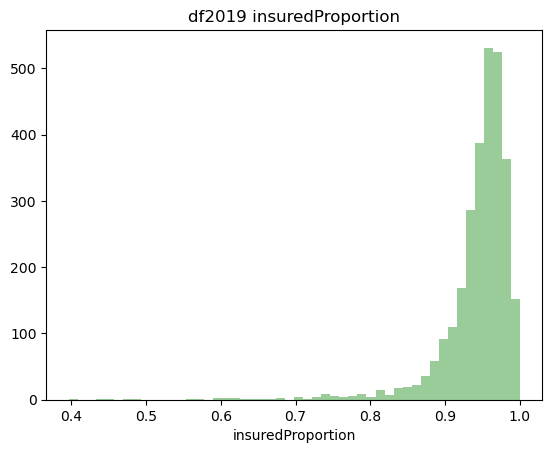

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2856.000000
mean        0.400008
std         0.152443
min         0.000000
25%         0.308070
50%         0.407407
75%         0.498136
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


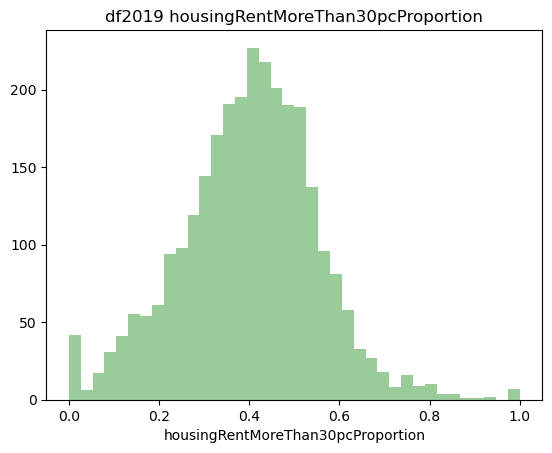

housingMedianValue
----------------------------------------------------------------------------
count    2.856000e+03
mean     2.303800e+05
std      2.127244e+05
min      2.720000e+04
25%      1.130000e+05
50%      1.600000e+05
75%      2.524000e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


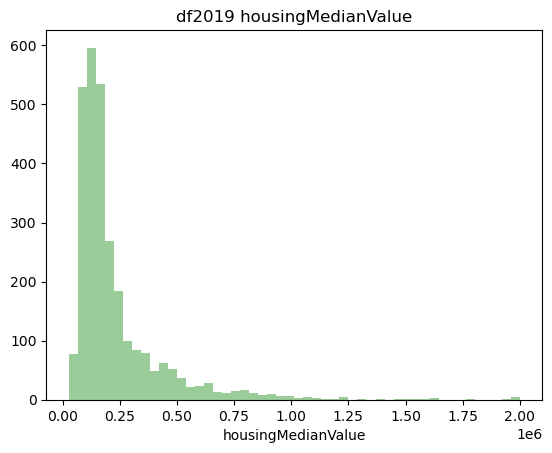

housingMedianGrossRent
----------------------------------------------------------------------------
count    2856.000000
mean     1001.792367
std       434.224649
min       323.000000
25%       718.000000
50%       856.000000
75%      1138.000000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


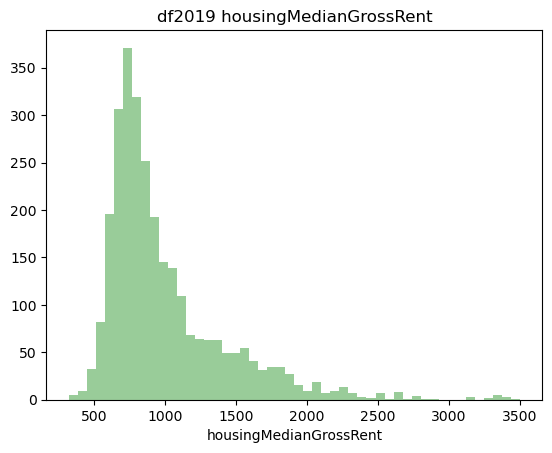

Description of columns for df2020
underPoverty
----------------------------------------------------------------------------
count    41.000000
mean      0.097561
std       0.300406
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


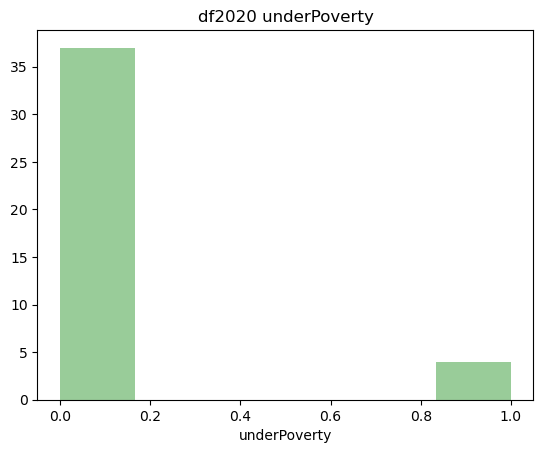

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.137187
std       0.076368
min       0.016632
25%       0.080492
50%       0.115537
75%       0.195664
max       0.333875
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


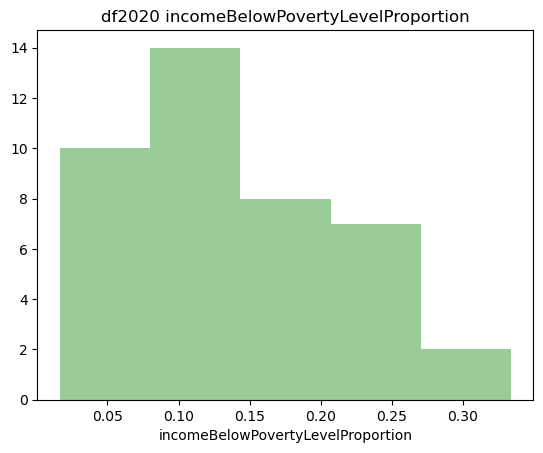

incomePerCapita
----------------------------------------------------------------------------
count        41.000000
mean      88079.219512
std       44251.043968
min       26109.000000
25%       36875.000000
50%      101031.000000
75%      123969.000000
max      182463.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


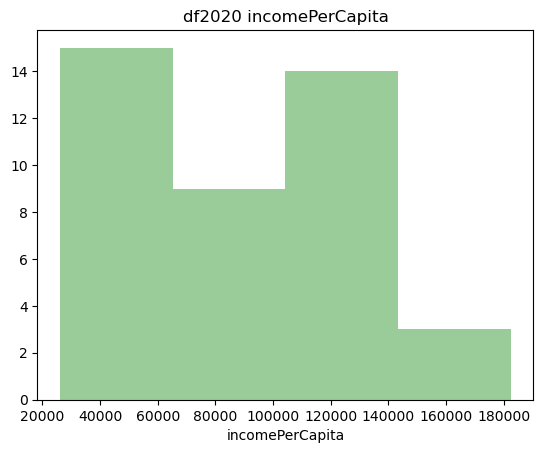

incomeGiniIndex
----------------------------------------------------------------------------
count    41.000000
mean      0.536961
std       0.054890
min       0.380500
25%       0.497700
50%       0.549200
75%       0.568500
max       0.626700
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


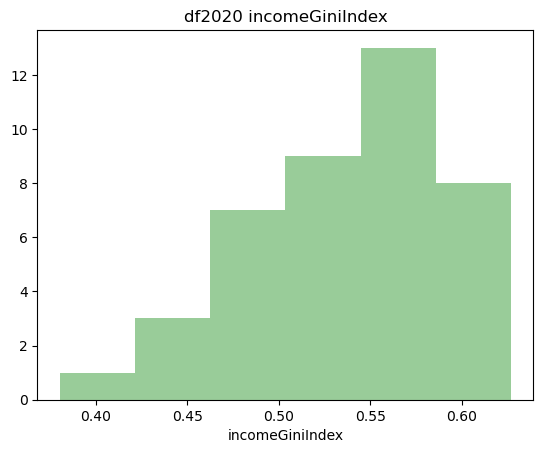

popDensity
----------------------------------------------------------------------------
count        41.000000
mean      78824.647610
std       32052.370236
min        6168.662000
25%       55504.800000
50%       76061.160000
75%       98371.770000
max      153099.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


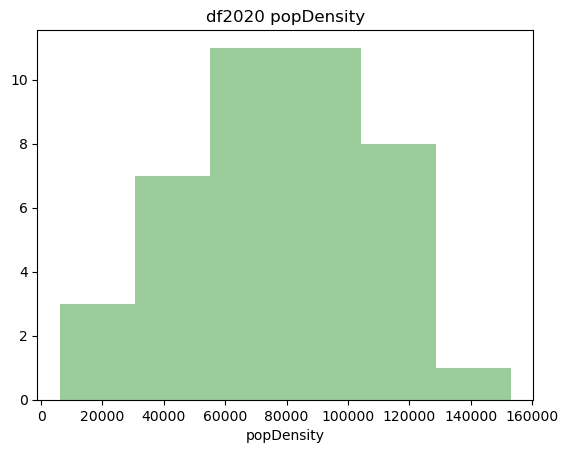

whiteMajority
----------------------------------------------------------------------------
count    41.000000
mean      0.565206
std       0.229258
min       0.121969
25%       0.330641
50%       0.634540
75%       0.745203
max       0.876131
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


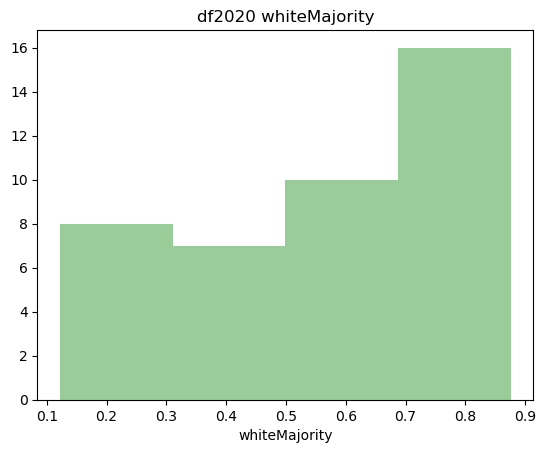

eduHsOrLessProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.103755
std       0.095502
min       0.000000
25%       0.023835
50%       0.073832
75%       0.170335
max       0.338570
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


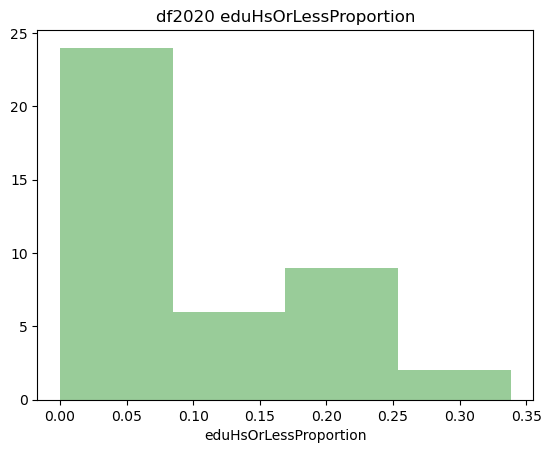

eduHsProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.239018
std       0.125484
min       0.055536
25%       0.146194
50%       0.203680
75%       0.368416
max       0.511558
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


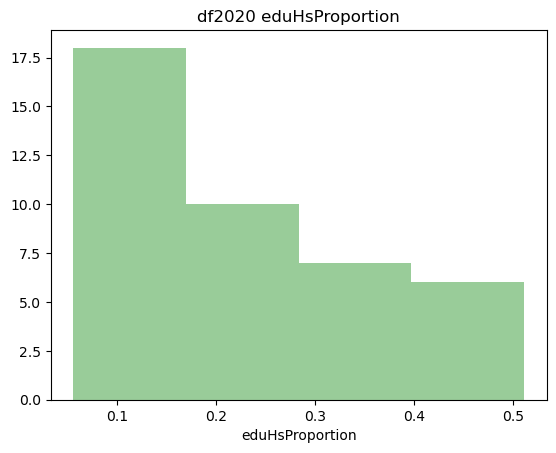

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.657228
std       0.209808
min       0.289622
25%       0.422333
50%       0.736736
75%       0.825608
max       0.939979
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


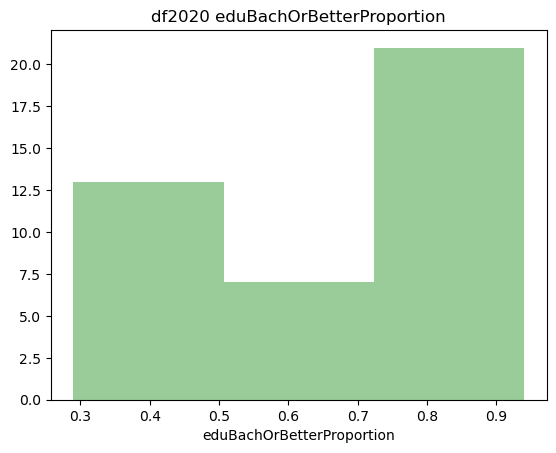

eduEnrollmentProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.192781
std       0.059076
min       0.067281
25%       0.154203
50%       0.198624
75%       0.234752
max       0.364898
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


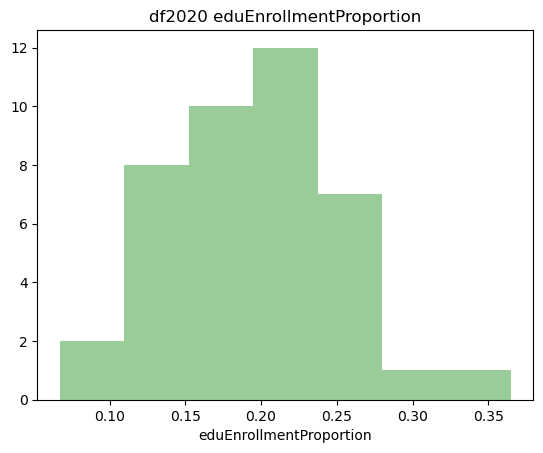

eduDropoutProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.030283
std       0.054250
min       0.000000
25%       0.000000
50%       0.003927
75%       0.038462
max       0.287234
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


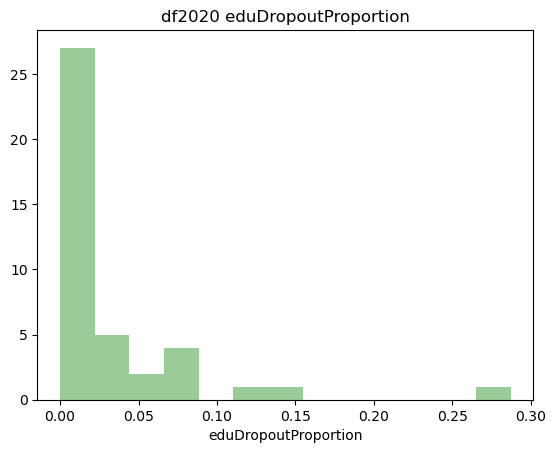

employedProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.943552
std       0.030417
min       0.868605
25%       0.930832
50%       0.954636
75%       0.961427
max       0.985880
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


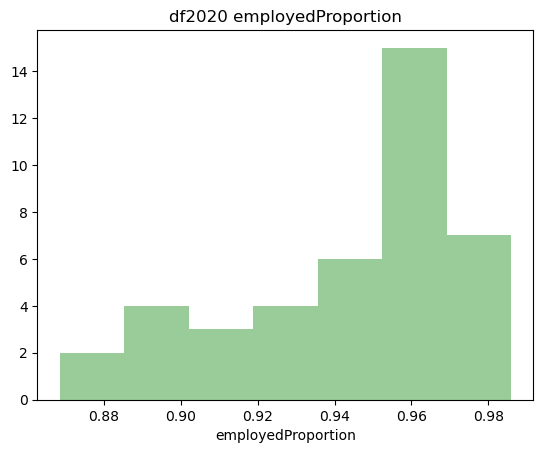

employedPvtSecProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.670007
std       0.060737
min       0.529861
25%       0.646681
50%       0.670868
75%       0.696960
max       0.825595
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


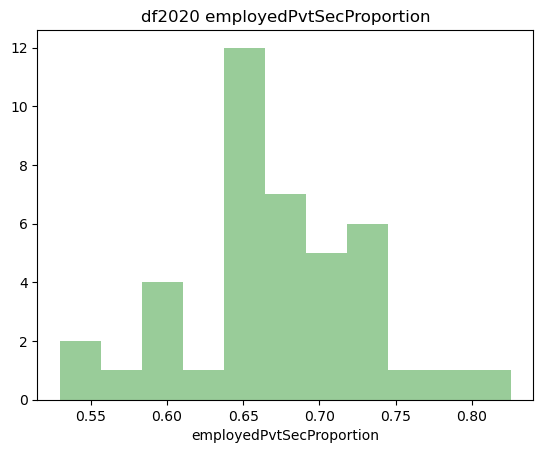

employedPubSecProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.088816
std       0.043878
min       0.030567
25%       0.056131
50%       0.077519
75%       0.113449
max       0.213587
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


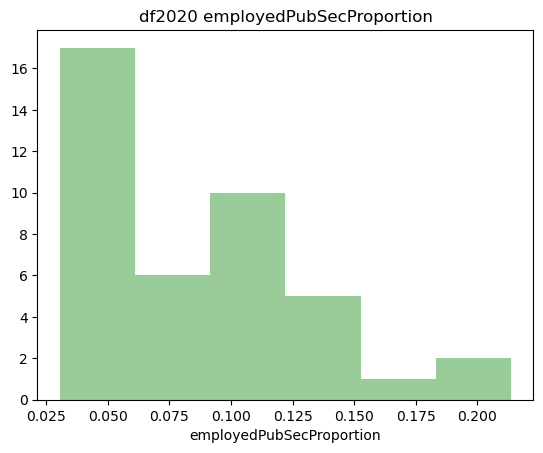

employedSelfEmpProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.116169
std       0.040286
min       0.049365
25%       0.083652
50%       0.112442
75%       0.145330
max       0.208350
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


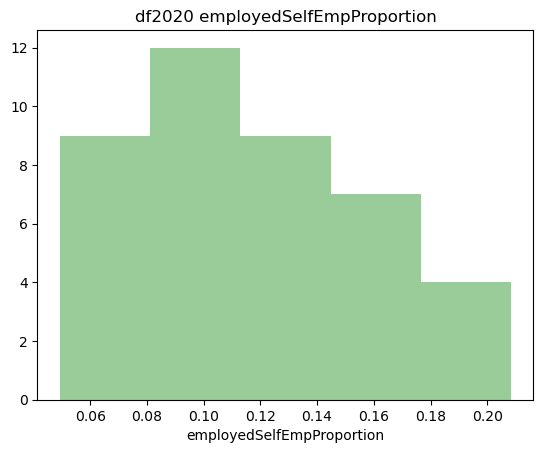

employedPvtNonProProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.123495
std       0.041966
min       0.031463
25%       0.089256
50%       0.123801
75%       0.147639
max       0.246923
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


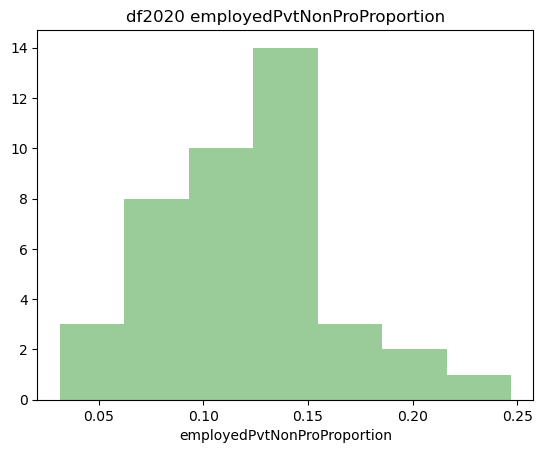

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.001512
std       0.002566
min       0.000000
25%       0.000000
50%       0.000656
75%       0.001762
max       0.013785
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


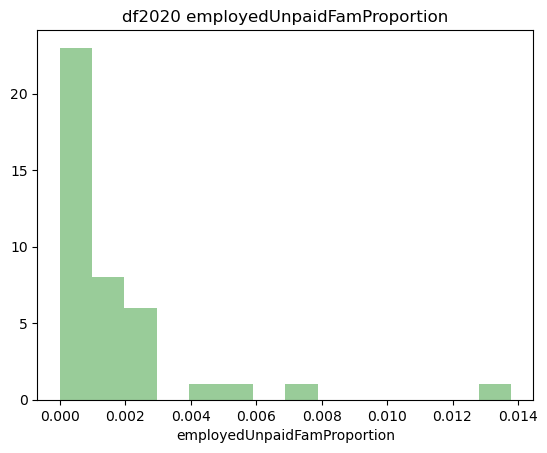

insuredProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.956326
std       0.025733
min       0.886050
25%       0.937417
50%       0.965131
75%       0.973560
max       0.998226
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


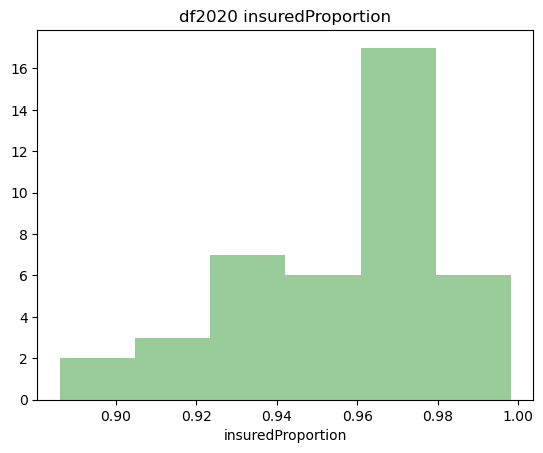

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    41.000000
mean      0.415253
std       0.068483
min       0.293333
25%       0.369118
50%       0.415786
75%       0.450386
max       0.544919
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


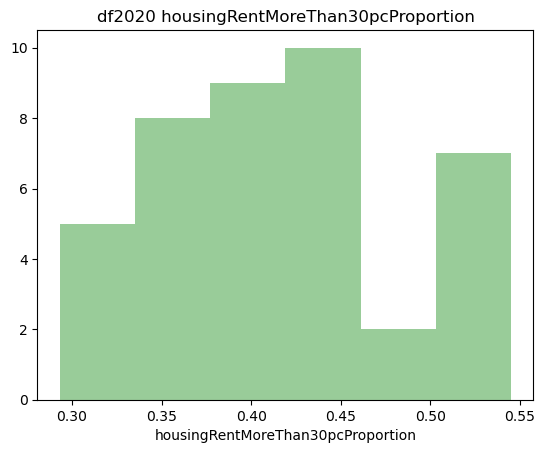

housingMedianValue
----------------------------------------------------------------------------
count    4.100000e+01
mean     1.005032e+06
std      4.767211e+05
min      3.750000e+05
25%      6.513000e+05
50%      9.413000e+05
75%      1.236900e+06
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


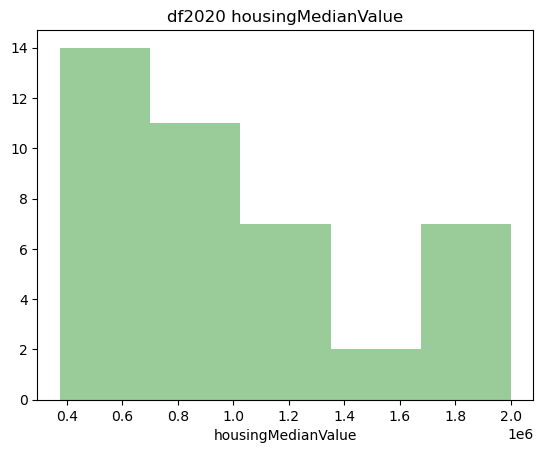

housingMedianGrossRent
----------------------------------------------------------------------------
count      41.000000
mean     2088.341463
std       746.583706
min       882.000000
25%      1417.000000
50%      2184.000000
75%      2524.000000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


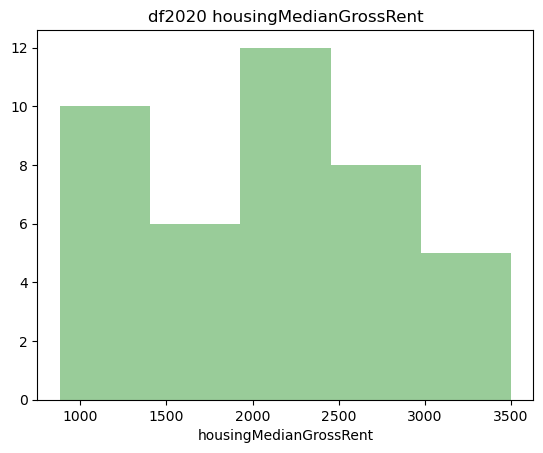

Description of columns for df2021
underPoverty
----------------------------------------------------------------------------
count    2762.000000
mean        0.051412
std         0.220877
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: underPoverty, dtype: float64 
----------------------------------------------------------------------------
Distribution of underPoverty
----------------------------------------------------------------------------


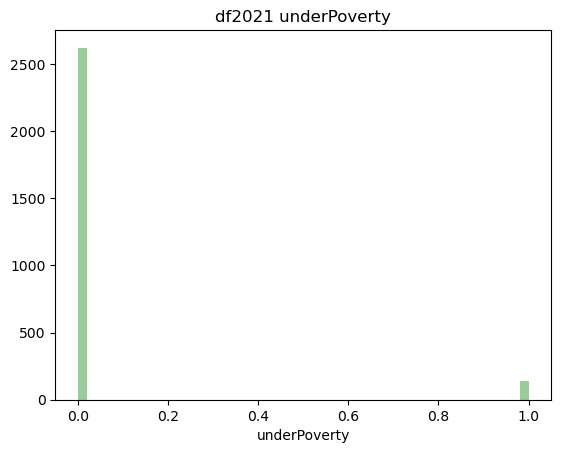

incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.102493
std         0.063519
min         0.000000
25%         0.058270
50%         0.089018
75%         0.130092
max         0.473985
Name: incomeBelowPovertyLevelProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeBelowPovertyLevelProportion
----------------------------------------------------------------------------


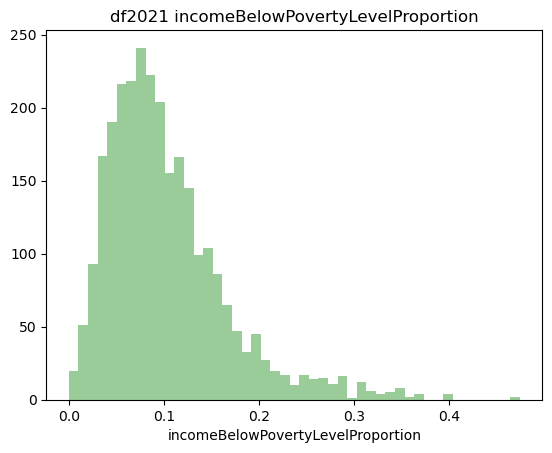

incomePerCapita
----------------------------------------------------------------------------
count      2762.000000
mean      37852.136495
std       17263.249927
min        5116.000000
25%       28145.750000
50%       33431.500000
75%       41647.750000
max      180412.000000
Name: incomePerCapita, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomePerCapita
----------------------------------------------------------------------------


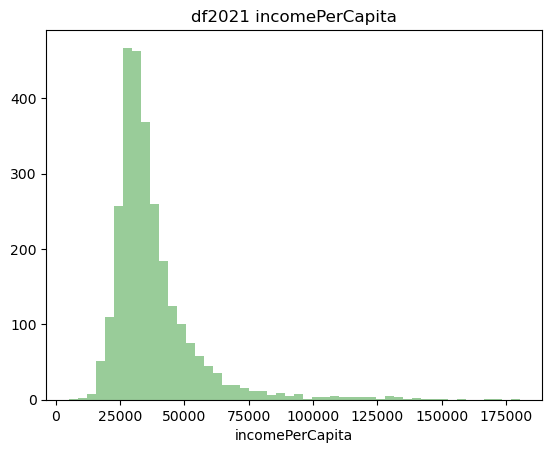

incomeGiniIndex
----------------------------------------------------------------------------
count    2762.000000
mean        0.421892
std         0.058448
min         0.156100
25%         0.384850
50%         0.417300
75%         0.455200
max         0.657200
Name: incomeGiniIndex, dtype: float64 
----------------------------------------------------------------------------
Distribution of incomeGiniIndex
----------------------------------------------------------------------------


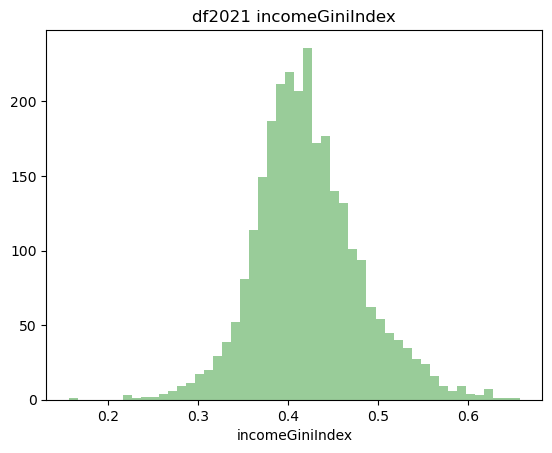

popDensity
----------------------------------------------------------------------------
count      2762.000000
mean       4194.044220
std       13579.232200
min           0.834195
25%          66.830888
50%         271.956550
75%        1854.641000
max      151475.800000
Name: popDensity, dtype: float64 
----------------------------------------------------------------------------
Distribution of popDensity
----------------------------------------------------------------------------


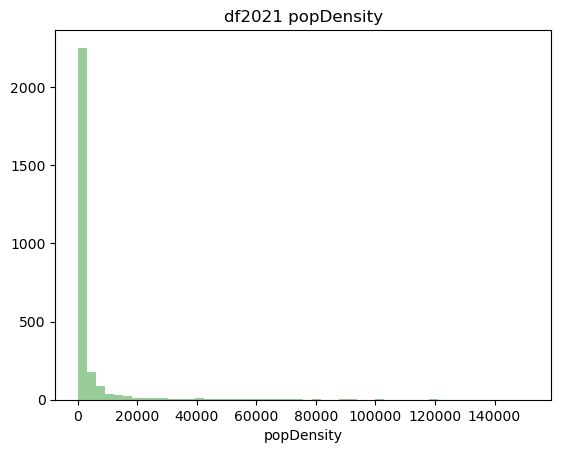

whiteMajority
----------------------------------------------------------------------------
count    2762.000000
mean        0.842032
std         0.196410
min         0.019053
25%         0.802563
50%         0.921079
75%         0.964396
max         1.000000
Name: whiteMajority, dtype: float64 
----------------------------------------------------------------------------
Distribution of whiteMajority
----------------------------------------------------------------------------


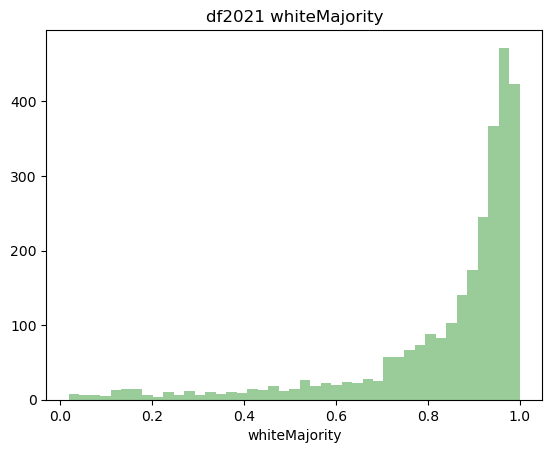

eduHsOrLessProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.096271
std         0.063522
min         0.000000
25%         0.053964
50%         0.082997
75%         0.119928
max         0.528090
Name: eduHsOrLessProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsOrLessProportion
----------------------------------------------------------------------------


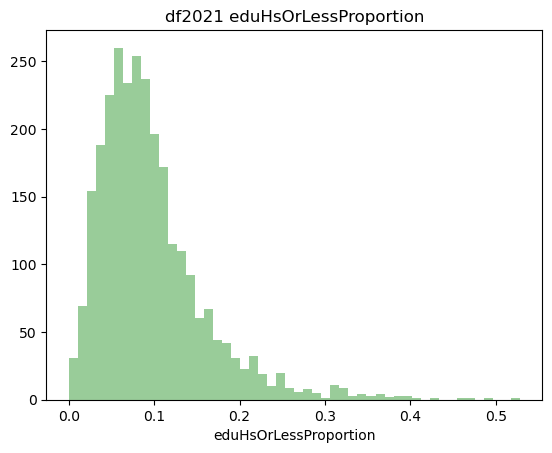

eduHsProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.610639
std         0.148644
min         0.030905
25%         0.536000
50%         0.644533
75%         0.715765
max         0.930636
Name: eduHsProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduHsProportion
----------------------------------------------------------------------------


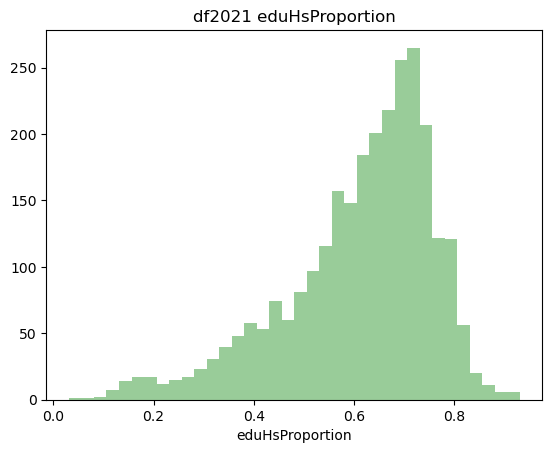

eduBachOrBetterProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.293090
std         0.166977
min         0.012195
25%         0.172751
50%         0.247534
75%         0.374775
max         0.965508
Name: eduBachOrBetterProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduBachOrBetterProportion
----------------------------------------------------------------------------


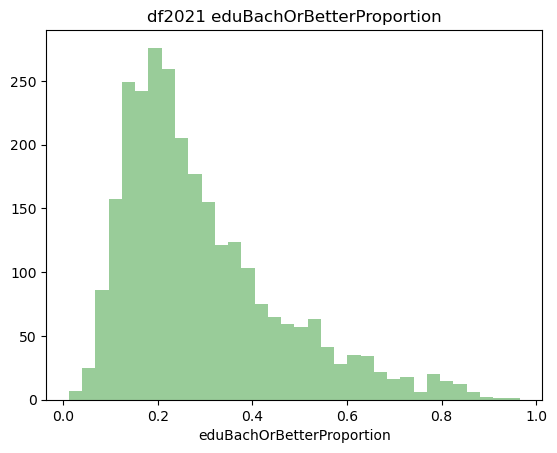

eduEnrollmentProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.218905
std         0.063484
min         0.000000
25%         0.183830
50%         0.215234
75%         0.248454
max         0.876300
Name: eduEnrollmentProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduEnrollmentProportion
----------------------------------------------------------------------------


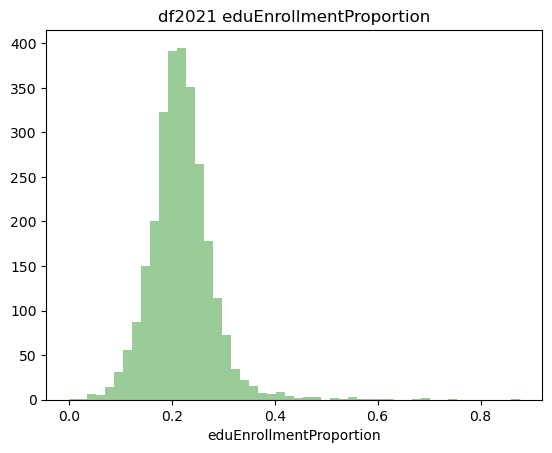

eduDropoutProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.055753
std         0.113325
min         0.000000
25%         0.000000
50%         0.011113
75%         0.058097
max         1.000000
Name: eduDropoutProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of eduDropoutProportion
----------------------------------------------------------------------------


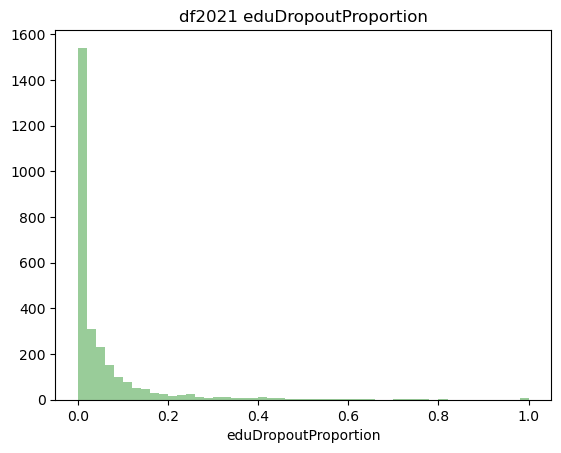

employedProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.945659
std         0.033943
min         0.672566
25%         0.931652
50%         0.951351
75%         0.967480
max         1.000000
Name: employedProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedProportion
----------------------------------------------------------------------------


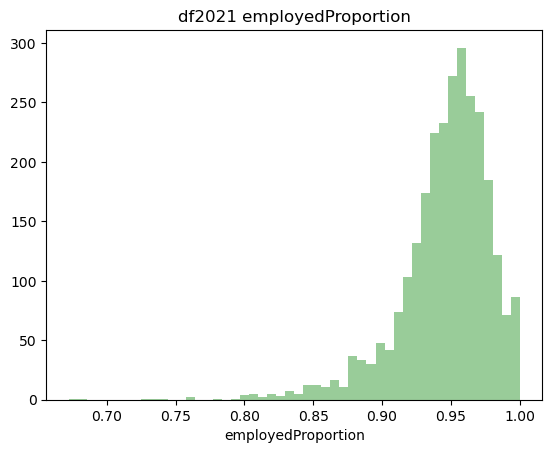

employedPvtSecProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.643166
std         0.094417
min         0.177778
25%         0.591457
50%         0.651538
75%         0.703504
max         0.965035
Name: employedPvtSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtSecProportion
----------------------------------------------------------------------------


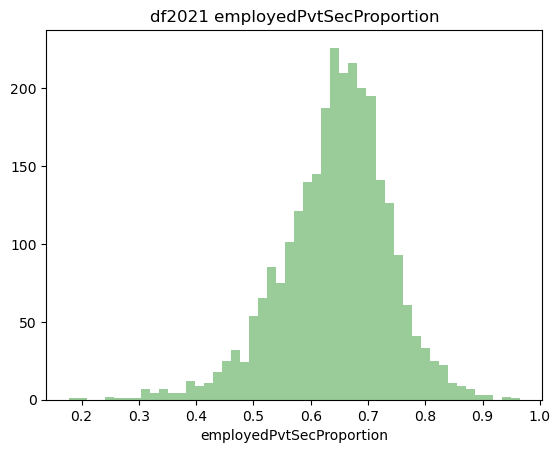

employedPubSecProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.149205
std         0.069294
min         0.000000
25%         0.099606
50%         0.140871
75%         0.187346
max         0.655556
Name: employedPubSecProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPubSecProportion
----------------------------------------------------------------------------


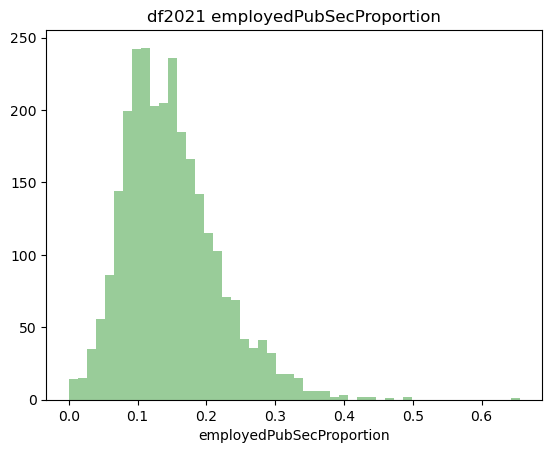

employedSelfEmpProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.096581
std         0.051785
min         0.000000
25%         0.062881
50%         0.086922
75%         0.118828
max         0.444238
Name: employedSelfEmpProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedSelfEmpProportion
----------------------------------------------------------------------------


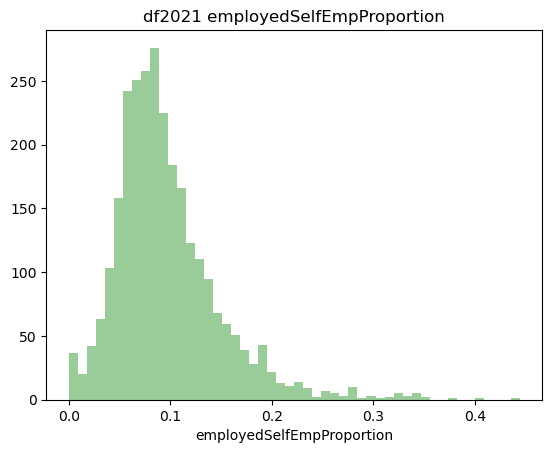

employedPvtNonProProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.108756
std         0.050685
min         0.000000
25%         0.077732
50%         0.102559
75%         0.132468
max         0.534653
Name: employedPvtNonProProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedPvtNonProProportion
----------------------------------------------------------------------------


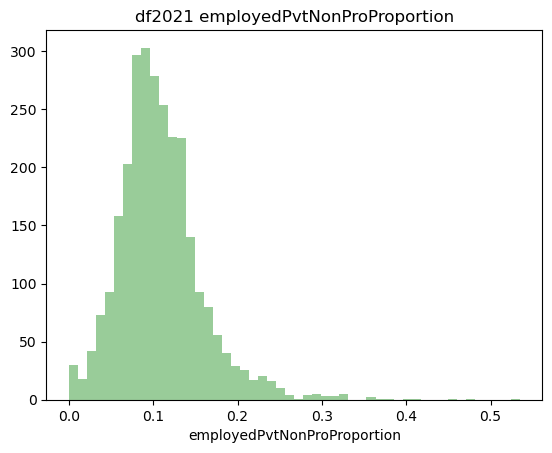

employedUnpaidFamProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.002291
std         0.006065
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002183
max         0.115092
Name: employedUnpaidFamProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of employedUnpaidFamProportion
----------------------------------------------------------------------------


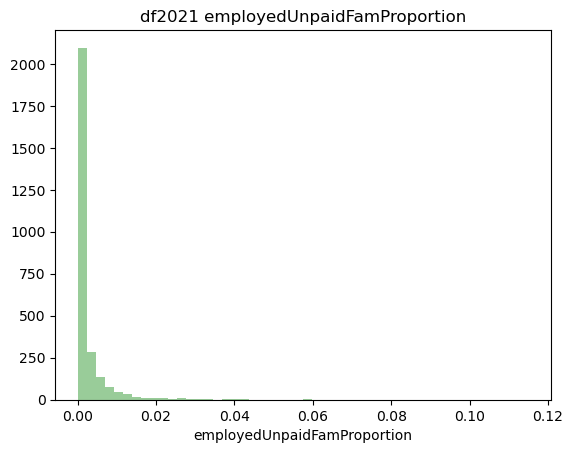

insuredProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.944078
std         0.054047
min         0.393746
25%         0.933320
50%         0.956894
75%         0.973802
max         1.000000
Name: insuredProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of insuredProportion
----------------------------------------------------------------------------


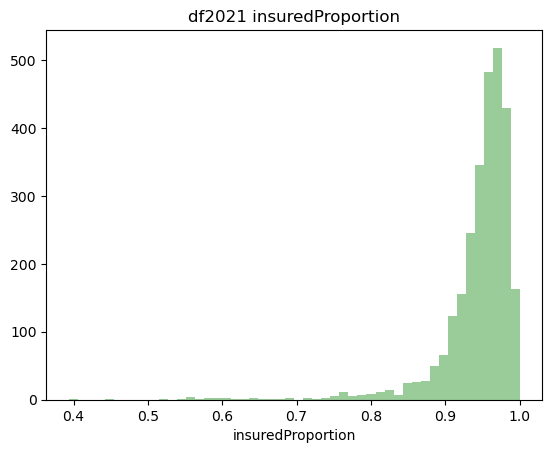

housingRentMoreThan30pcProportion
----------------------------------------------------------------------------
count    2762.000000
mean        0.391692
std         0.158037
min         0.000000
25%         0.289294
50%         0.400691
75%         0.495768
max         1.000000
Name: housingRentMoreThan30pcProportion, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingRentMoreThan30pcProportion
----------------------------------------------------------------------------


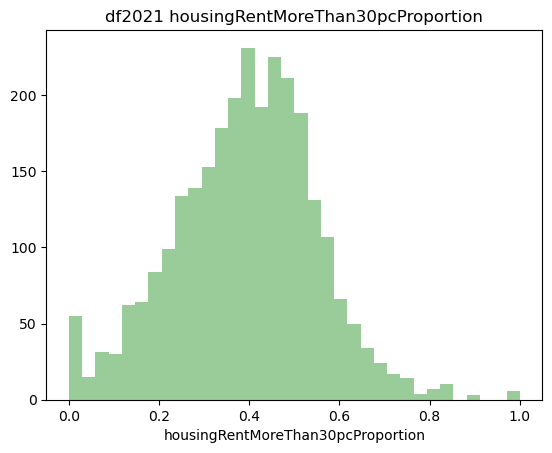

housingMedianValue
----------------------------------------------------------------------------
count    2.762000e+03
mean     2.482243e+05
std      2.244529e+05
min      9.999000e+03
25%      1.219250e+05
50%      1.708000e+05
75%      2.732750e+05
max      2.000001e+06
Name: housingMedianValue, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianValue
----------------------------------------------------------------------------


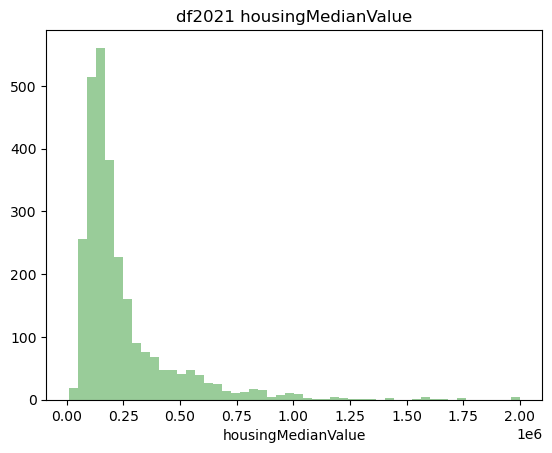

housingMedianGrossRent
----------------------------------------------------------------------------
count    2762.000000
mean     1073.119841
std       472.617585
min       379.000000
25%       754.000000
50%       921.000000
75%      1232.750000
max      3501.000000
Name: housingMedianGrossRent, dtype: float64 
----------------------------------------------------------------------------
Distribution of housingMedianGrossRent
----------------------------------------------------------------------------


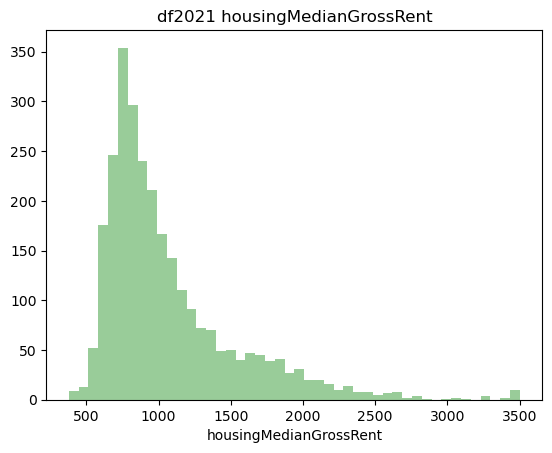

Wall time: 24.6 s


In [10]:
%%time
for key, df in dfs.items(): 
    print(f"Description of columns for {key}")
    for column in columnNames:
        print(column)
        print("----------------------------------------------------------------------------")
        print(df[column].describe(),end=' ')


        plt.figure()
        plt.title(key+" "+column)
        print("\n----------------------------------------------------------------------------")
        print("Distribution of " + column)
        print("----------------------------------------------------------------------------")
        sns.distplot(df[column], kde=False, color='g');
        plt.show()


### Outlier Analysis

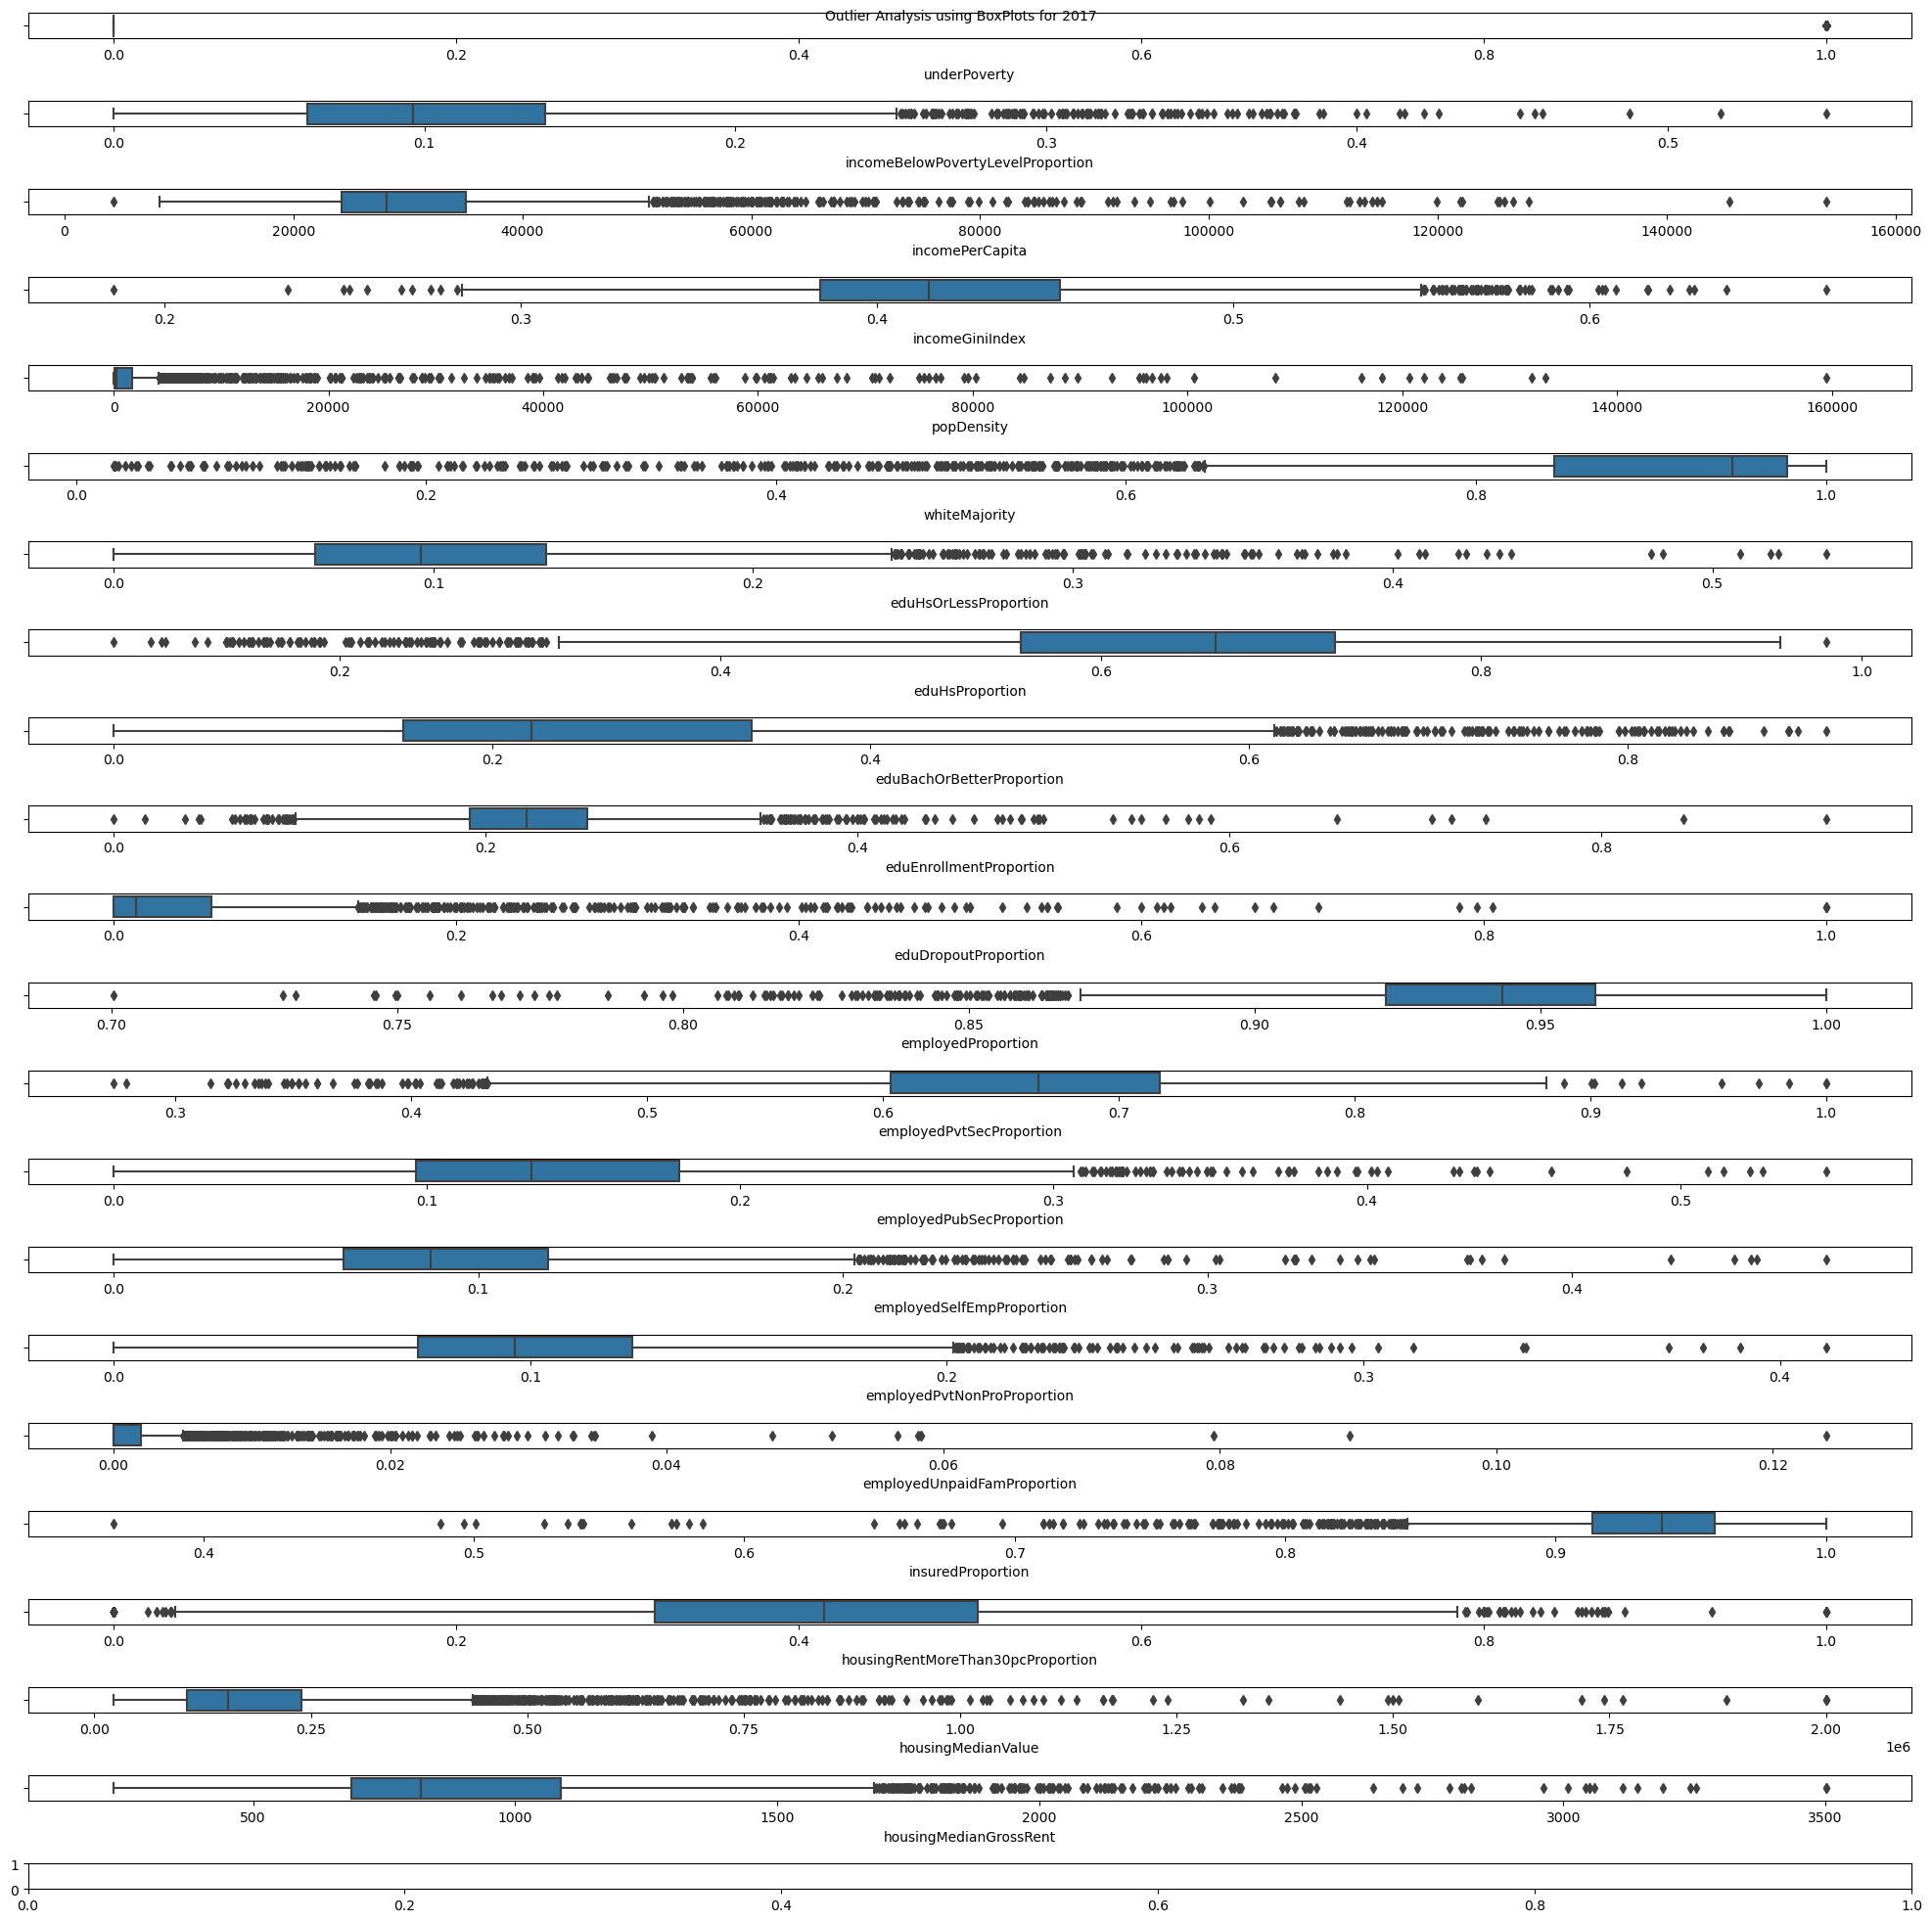

In [11]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()
for i, c in enumerate(dfs['df2017'].columns):
    sns.boxplot(x=dfs['df2017'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2017', fontsize=10)
fig.tight_layout()

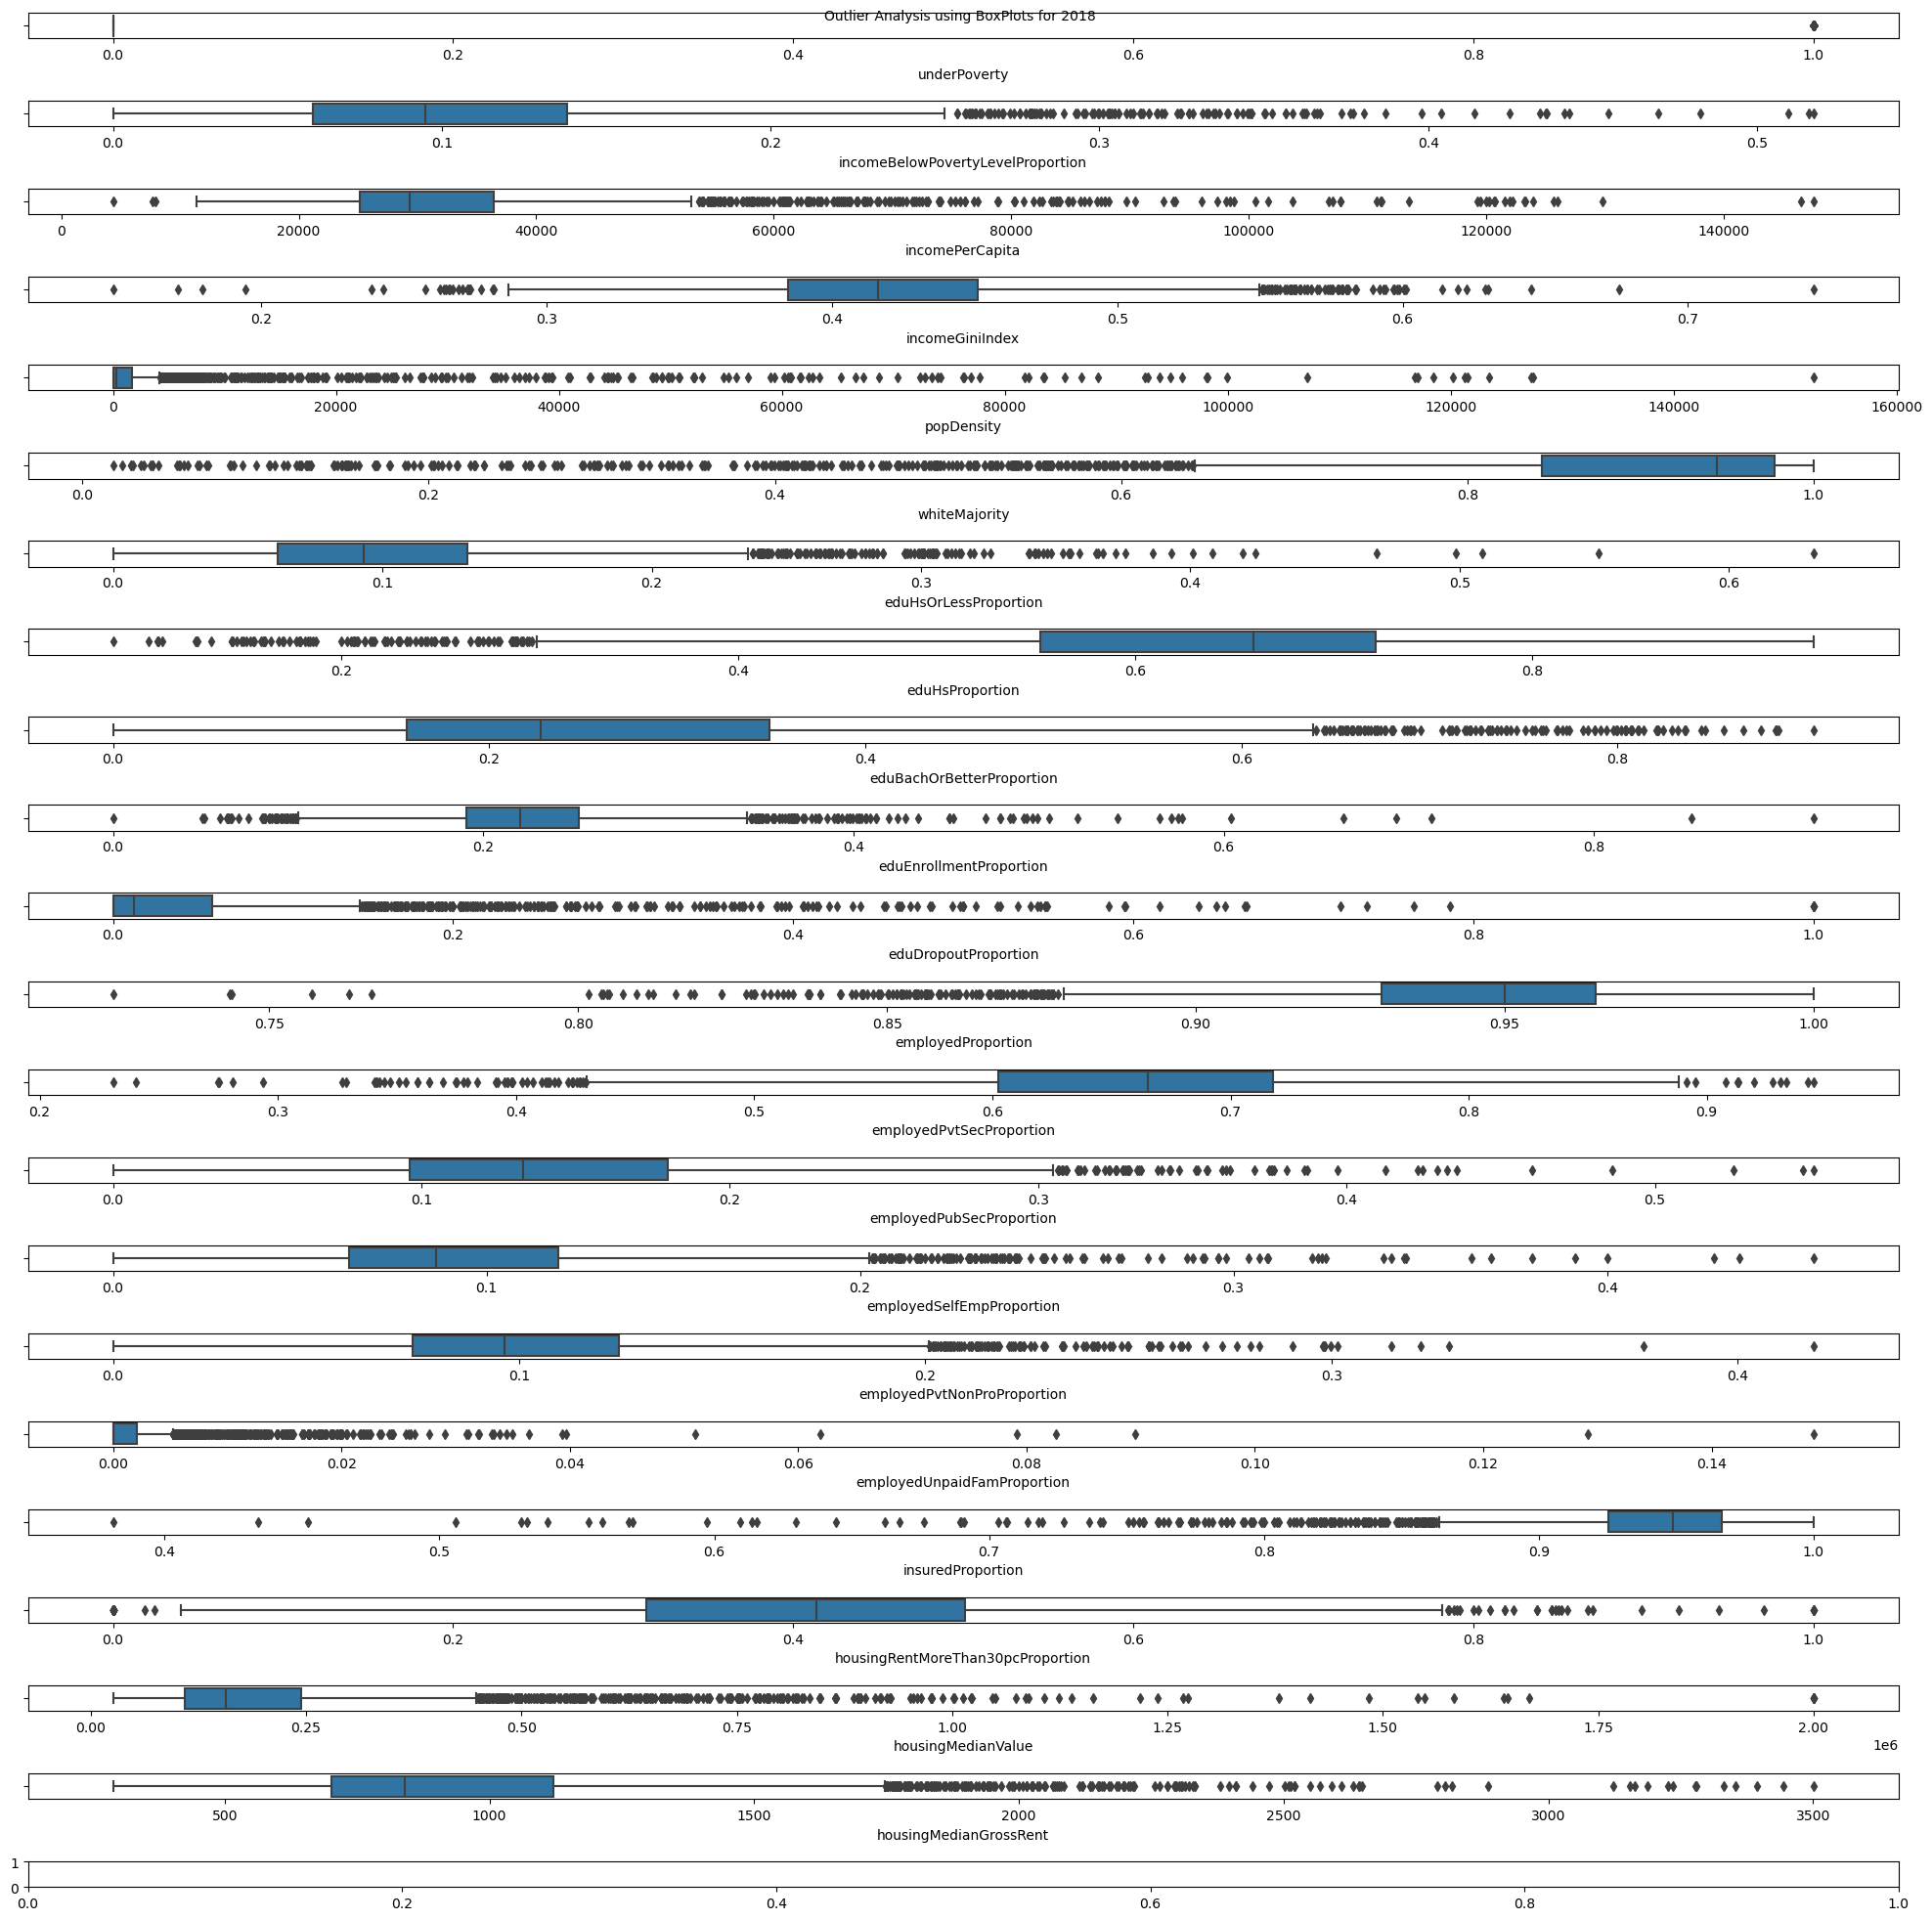

In [12]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2018'].columns):
    sns.boxplot(x=dfs['df2018'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2018', fontsize=10)
fig.tight_layout()

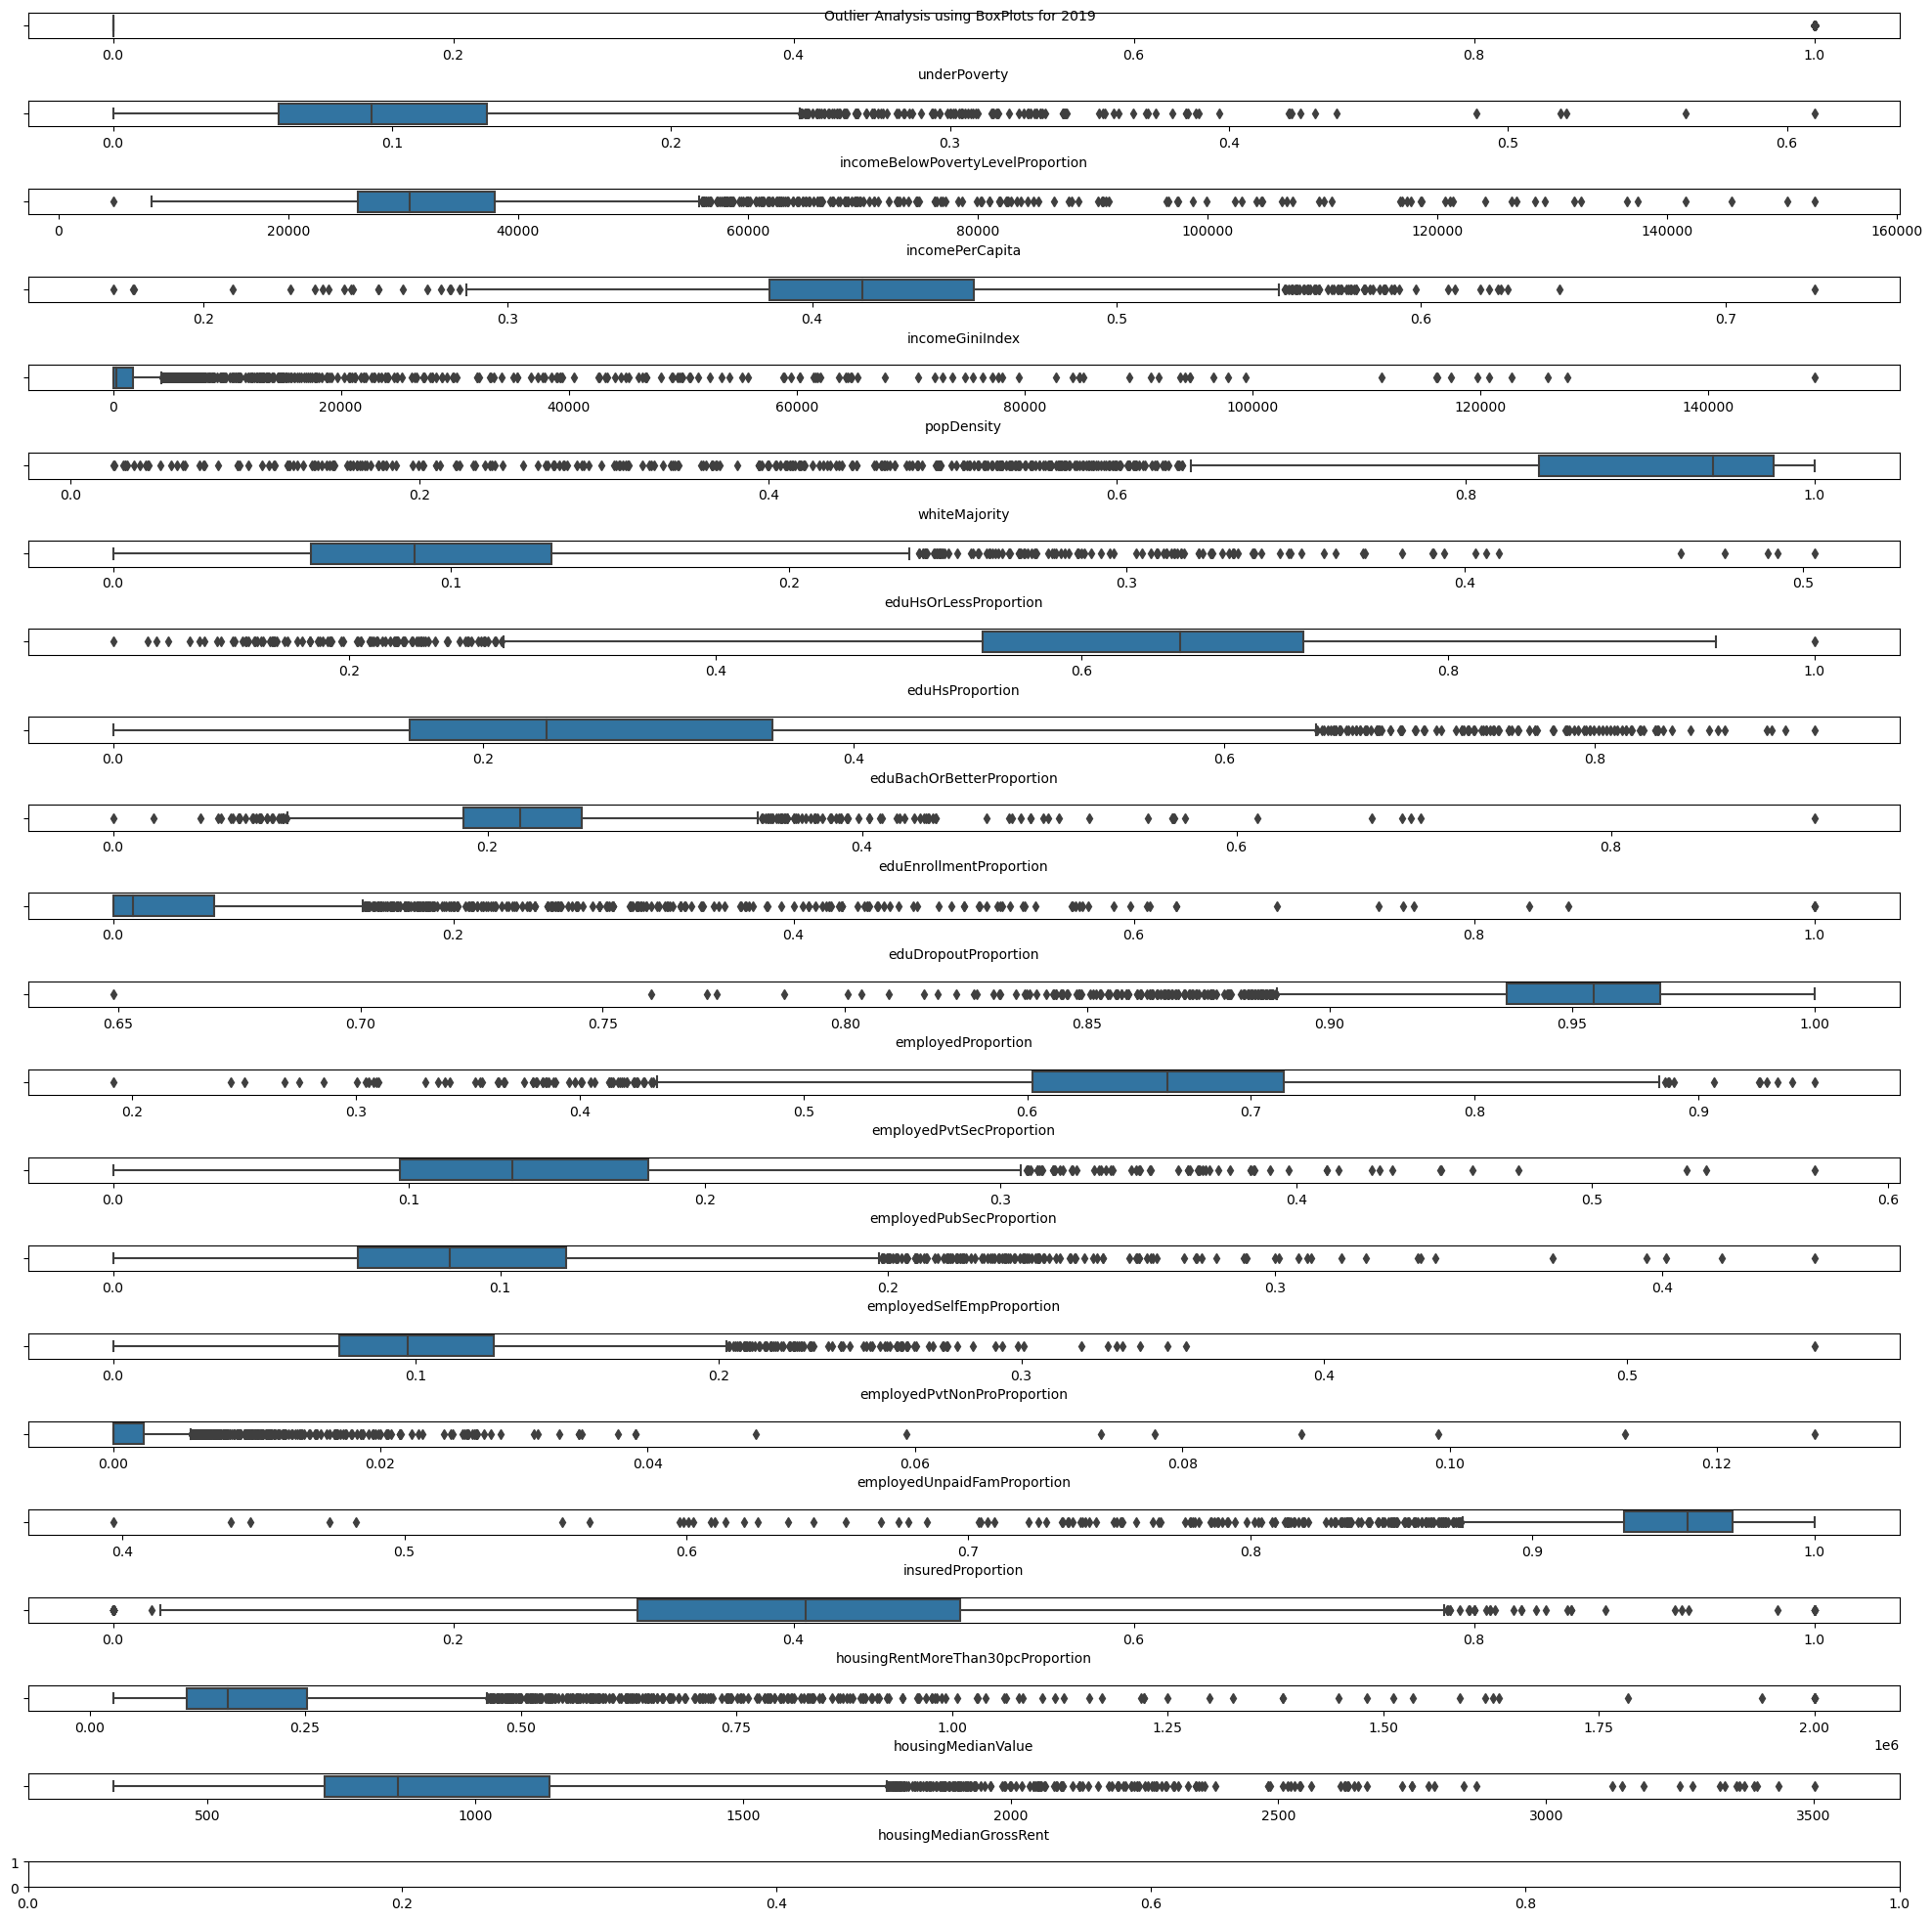

In [13]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2019'].columns):
    sns.boxplot(x=dfs['df2019'].iloc[:, i], ax=ax[i])
    #ax[i].set_title(c)
    
plt.suptitle('Outlier Analysis using BoxPlots for 2019', fontsize=10)
fig.tight_layout()

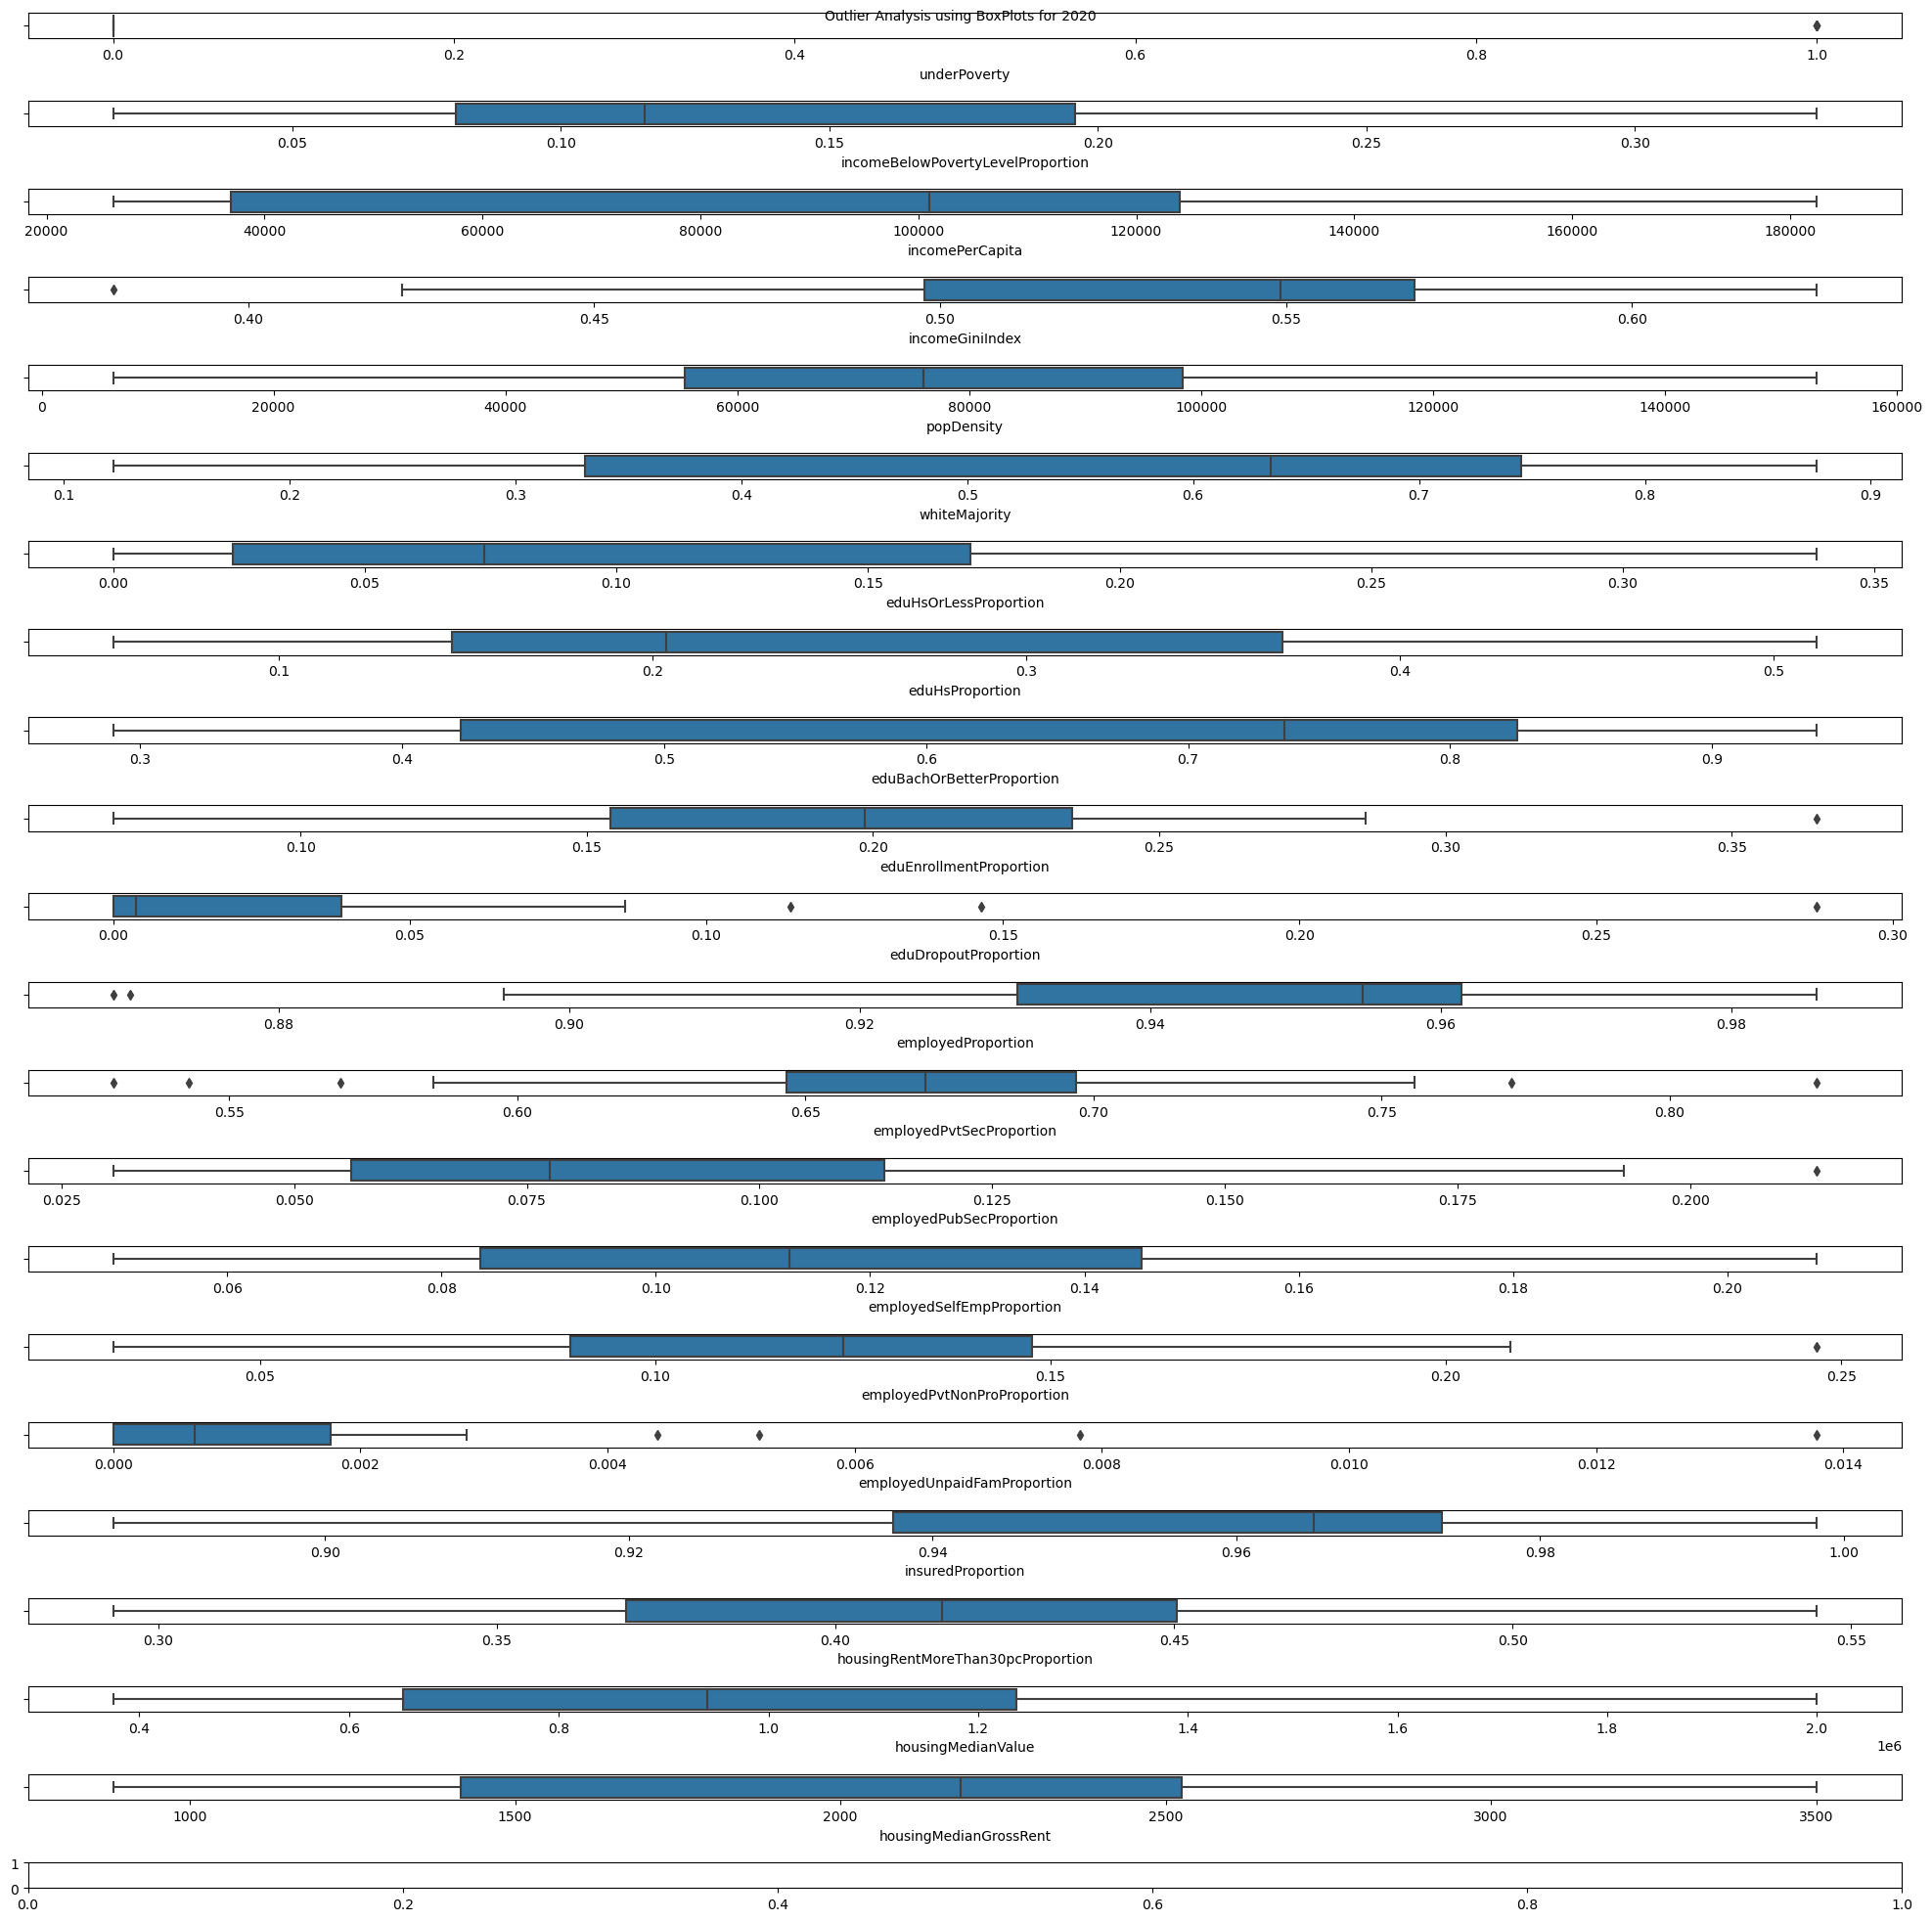

In [14]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2020'].columns):
    sns.boxplot(x=dfs['df2020'].iloc[:, i], ax=ax[i])
    
plt.suptitle('Outlier Analysis using BoxPlots for 2020', fontsize=10)
fig.tight_layout()

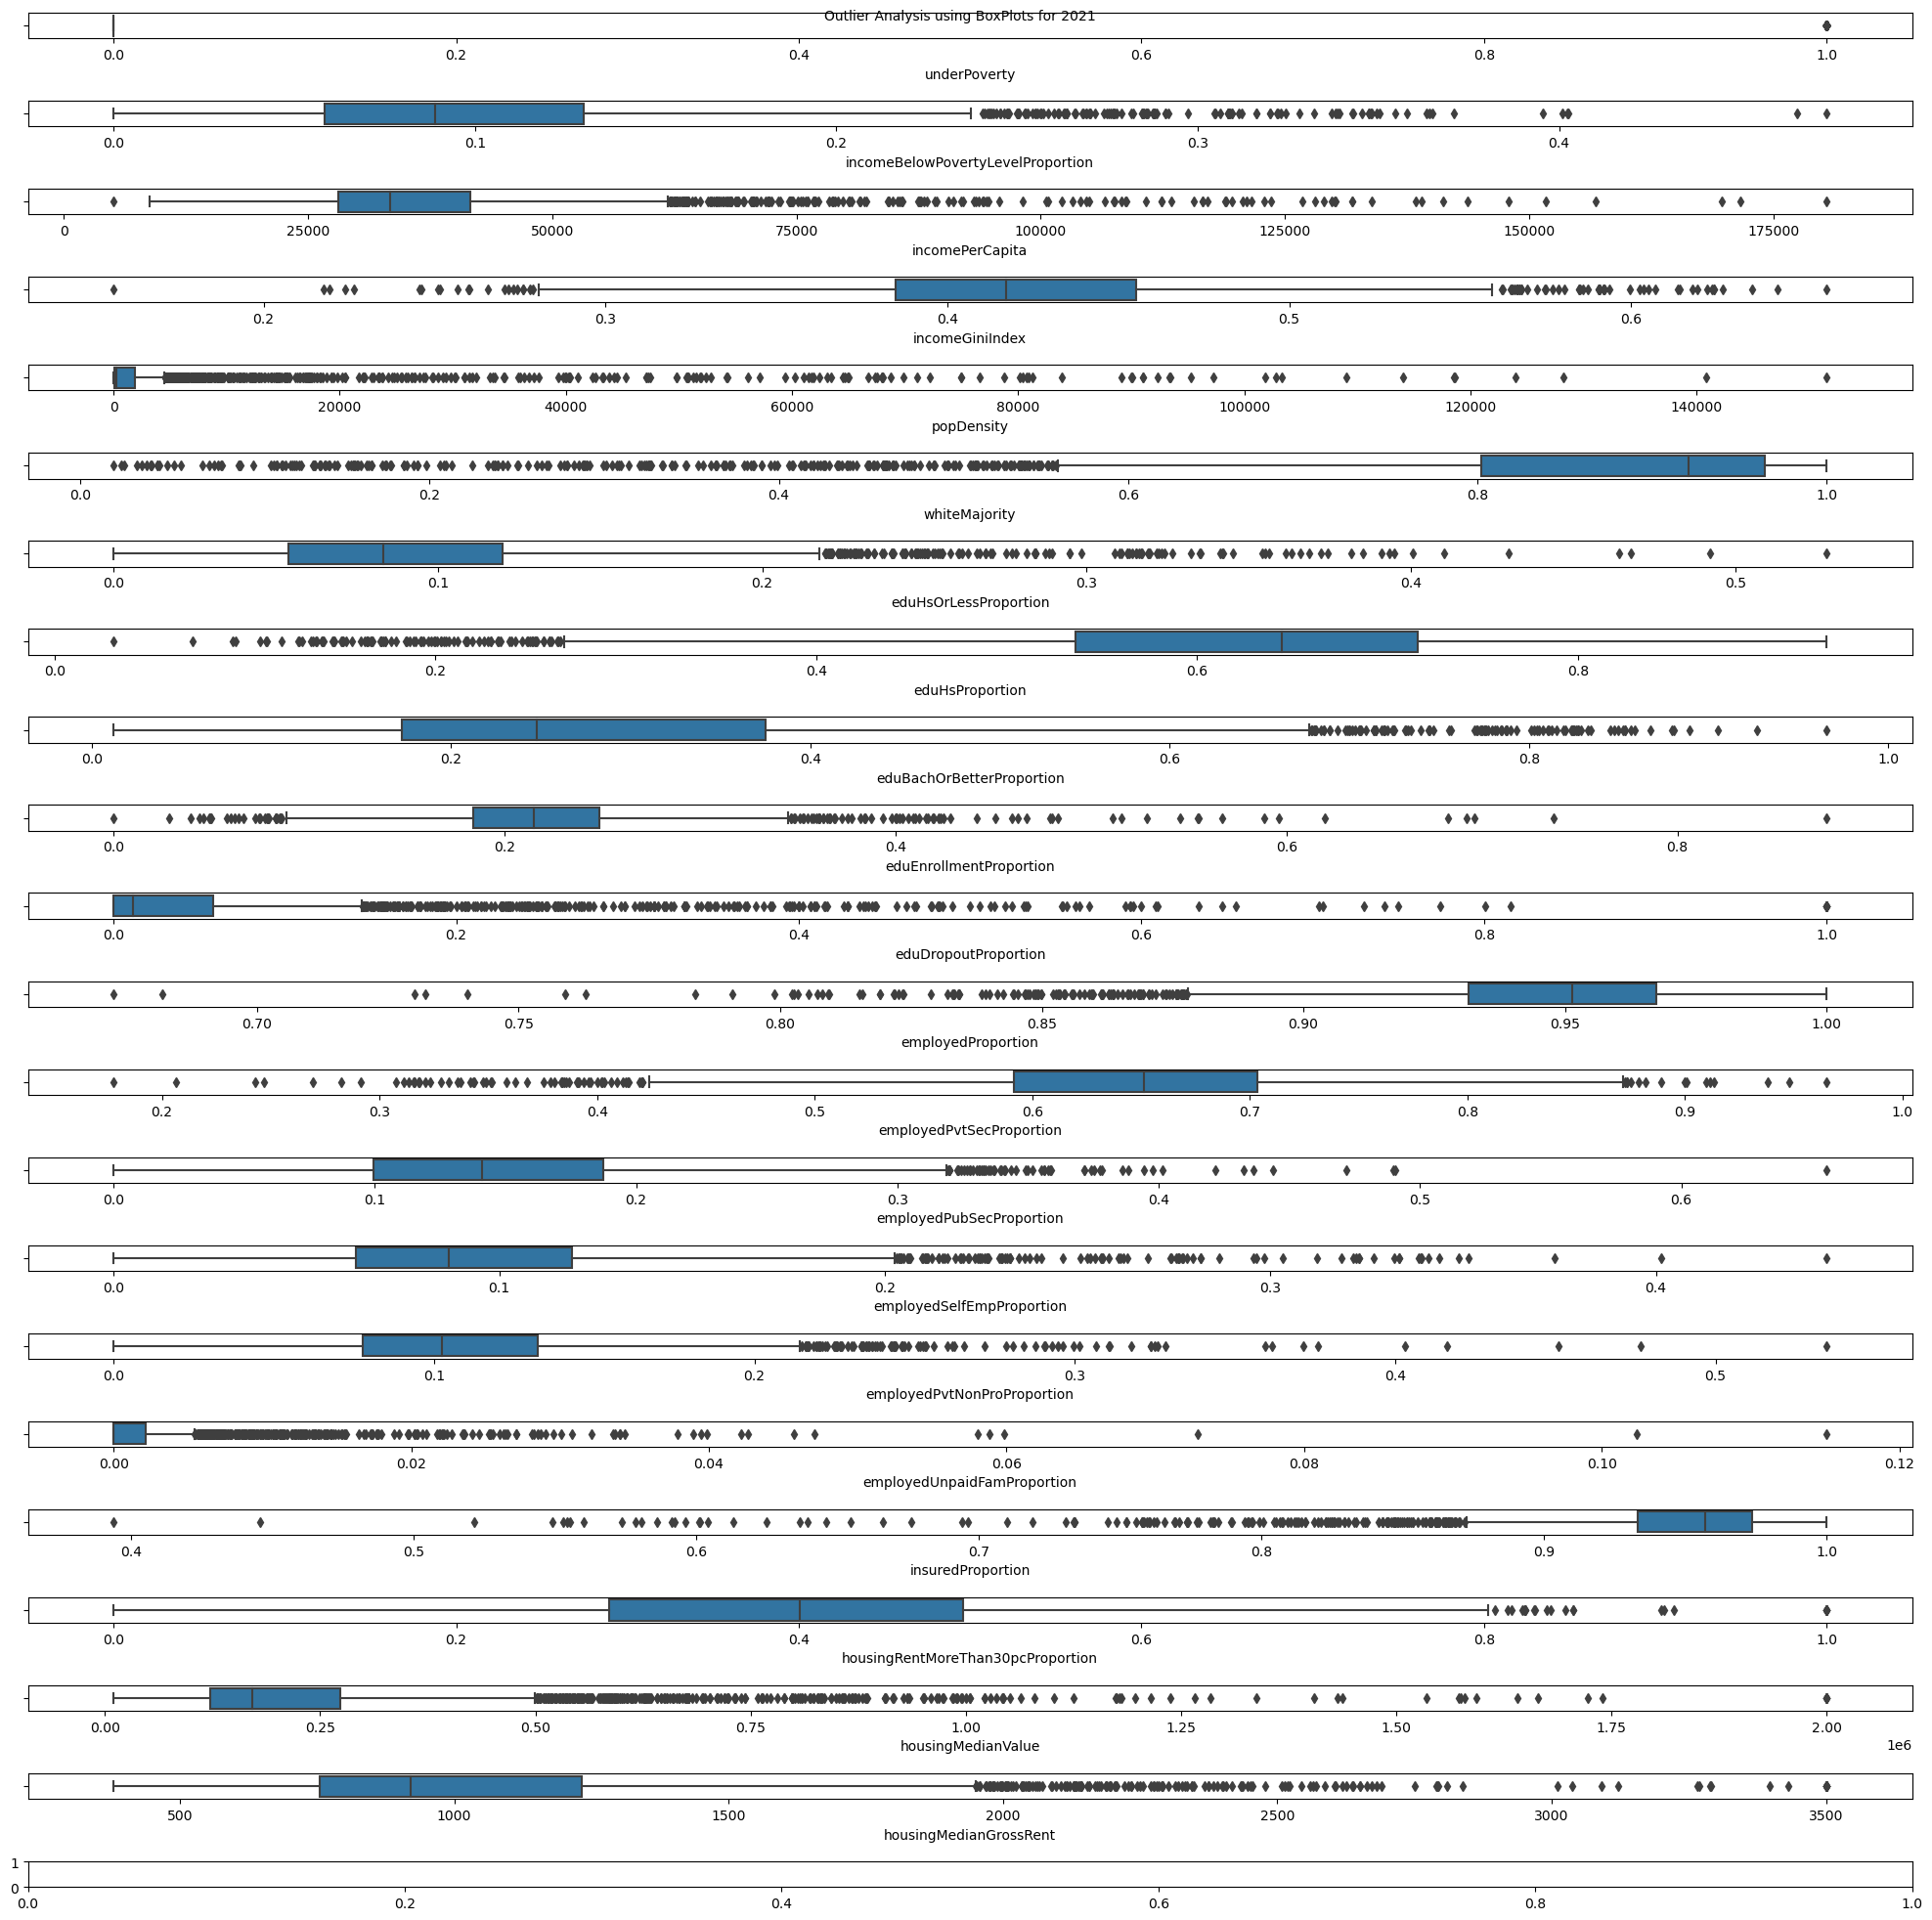

In [15]:
fig, ax = plt.subplots(22, figsize=(20, 20))
ax = ax.flatten()

for i, c in enumerate(dfs['df2021'].columns):
    sns.boxplot(x=dfs['df2021'].iloc[:, i], ax=ax[i])
    #ax[i].set_title(c)
    
plt.suptitle('Outlier Analysis using BoxPlots for 2021', fontsize=10)
fig.tight_layout()

### Interactive plot

Interactive scatter plot is created using widgets to do an exploratory bivariate analysis on different combinations of variables

In [16]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2017'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2017'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2017')
    fig = px.scatter(dfs['df2017'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2017'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [17]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2018'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2018'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2018')
    fig = px.scatter(dfs['df2018'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2018'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [18]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2019'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2019'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2019')
    fig = px.scatter(dfs['df2019'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2019'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [19]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2020'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2020'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2020')
    fig = px.scatter(dfs['df2020'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2020'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

In [20]:
# Create dropdown widgets for x and y axis variables
x_var_dropdown = widgets.Dropdown(options=list(dfs['df2021'].columns[2:]), description='X Axis')
y_var_dropdown = widgets.Dropdown(options=list(dfs['df2021'].columns[2:]), description='Y Axis')

# Define function to create the scatter plot
def scatterplot(x_var, y_var):
    print('Scatterplot for 2021')
    fig = px.scatter(dfs['df2021'], x=x_var, y=y_var, color='underPoverty', hover_data=[dfs['df2021'].index])
    fig.show()
    
# Create interactive plot using the scatterplot function and the dropdown widgets
interactive_plot = interact(scatterplot, x_var=x_var_dropdown, y_var=y_var_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='X Axis', options=('incomePerCapita', 'incomeGiniIndex', 'popDensit…

<function __main__.scatterplot(x_var, y_var)>

# <a id='my-heading_3'></a> Clustering

To find insights into the poverty status of different zip codes we implemented unsupervised clustering techniques (K-means and Agglomerative clustering).

However, before clustering, min-max scaling was implemented on 'popDensity', 'incomePerCapita', 'housingMedianValue', 'housingMedianGrossRent'. This is because clustering is a distance-based algorithm. All distance-based algorithms are affected by the scale of the variables. The variables mentioned before are on the scale of millions while other variables are in form of proportion ranging from 0 to 1.

## KMeans

In the following for loop, the four variables are being scaled, using MixMax Scaler. Then, wss plot is made to find the optimum number of clusters for each year.

Beginning df2017 clustering
Scaling df2017 columns
KMeans clustering on df2017
Beginning df2018 clustering
Scaling df2018 columns
KMeans clustering on df2018
Beginning df2019 clustering
Scaling df2019 columns
KMeans clustering on df2019
Beginning df2020 clustering
Scaling df2020 columns
KMeans clustering on df2020
Beginning df2021 clustering
Scaling df2021 columns
KMeans clustering on df2021
Wall time: 10.6 s


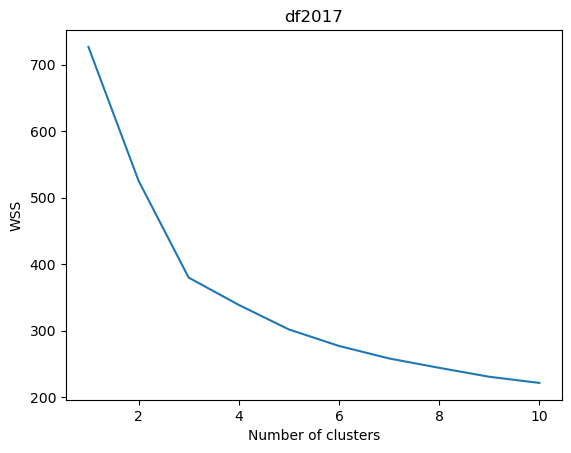

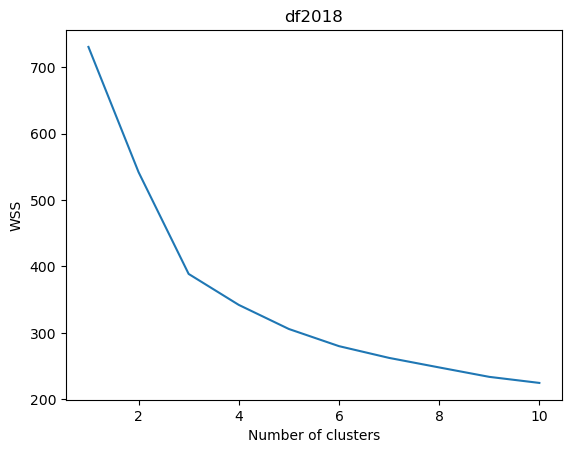

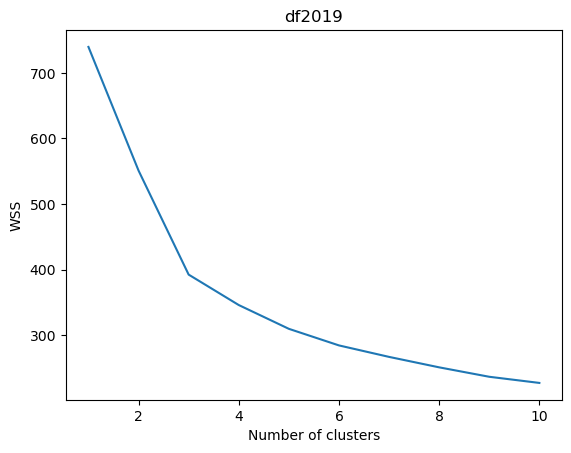

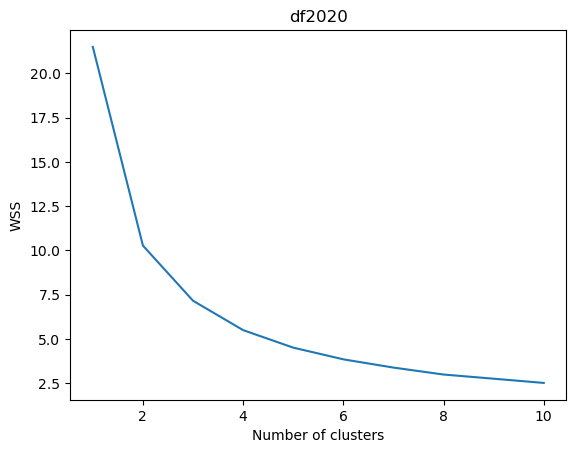

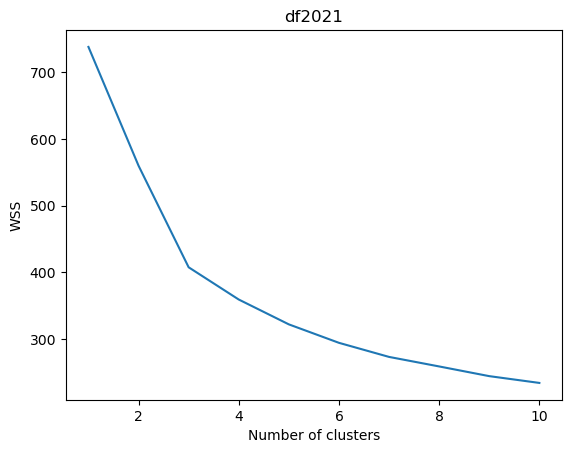

In [21]:
%%time
for key, df in dfs.items():
    print(f"Beginning {key} clustering")
    wss_df = []
    scaler = MinMaxScaler()
    print(f"Scaling {key} columns")
    scaler.fit(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']] = scaler.transform(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    print(f"KMeans clustering on {key}")
    for i in range(1,11):
        KM = KMeans(n_clusters=i)
        KM.fit(df)
        wss_df.append(KM.inertia_)
    plt.figure()
    plt.title(key)
    plt.xlabel("Number of clusters")
    plt.ylabel("WSS")
    plt.plot(range(1,11), wss_df)

In [22]:
for key, df in dfs.items():
    #Clustering with n=2
    k_means = KMeans(n_clusters = 2)
    k_means.fit(df)
    df['clus_kmeans'] = k_means.labels_

### Mean values of the two clusters
After fitting the data through the kmeans model, the data was summarized by grouping them in clusters. This gives a perspective on the charateristics of two clusters.

In [23]:
%%time
for key, df in dfs.items():
    display(key, df.groupby('clus_kmeans').mean())

'df2017'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.099324,0.189962,0.416399,0.020795,0.886117,0.101001,0.625267,0.273732,0.223476,...,0.940426,0.652812,0.145611,0.098252,0.101214,0.002111,0.931310,0.402221,0.100260,0.222421
1,1.0,0.273372,0.094146,0.468907,0.092567,0.589829,0.212302,0.626389,0.161309,0.274009,...,0.886804,0.687311,0.126071,0.071641,0.112821,0.002155,0.883546,0.507903,0.072042,0.173797


'df2018'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.098312,0.207157,0.417317,0.022629,0.882209,0.098352,0.621789,0.279859,0.220938,...,0.946933,0.652662,0.145072,0.098483,0.101507,0.002276,0.94049,0.398693,0.102034,0.217785
1,1.0,0.271247,0.103515,0.470212,0.082221,0.604366,0.207319,0.636368,0.156313,0.273524,...,0.895024,0.693374,0.118852,0.073078,0.113356,0.001340,0.89715,0.496339,0.064771,0.165990


'df2019'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.095851,0.207369,0.417920,0.022992,0.880210,0.095682,0.618405,0.285913,0.218086,...,0.951602,0.650772,0.146314,0.097535,0.103086,0.002292,0.945344,0.393905,0.104994,0.216776
1,1.0,0.264409,0.101535,0.470584,0.085975,0.611257,0.204993,0.635218,0.159790,0.277818,...,0.903588,0.690552,0.122288,0.074235,0.111116,0.001810,0.907297,0.495828,0.071530,0.163586


'df2020'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.092219,0.572798,0.537356,0.476418,0.707033,0.046793,0.158419,0.794788,0.169173,...,0.958997,0.688906,0.064336,0.134120,0.111277,0.001361,0.970040,0.382583,0.526081,0.626306
1,0.285714,0.223910,0.056045,0.536200,0.529344,0.291683,0.213609,0.394458,0.391933,0.238310,...,0.913765,0.633561,0.136029,0.081548,0.147059,0.001803,0.929877,0.478259,0.120857,0.141057


'df2021'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.032603,0.101306,0.155963,0.407242,0.003707,0.921016,0.097208,0.679195,0.223597,0.205740,...,0.947645,0.649671,0.150106,0.093597,0.104054,0.002572,0.940124,0.357962,0.073354,0.153931
1,0.097622,0.105409,0.262380,0.457887,0.086587,0.647982,0.093968,0.442211,0.463821,0.251248,...,0.940780,0.627183,0.146992,0.103915,0.120309,0.001601,0.953794,0.474563,0.233601,0.390381


Wall time: 225 ms


#### From the cluster and underPoverty values, we can observe that for 2020, clustering is opposite when compared with other years.
#### To maintain homogeneity, we will swap the cluster values for these two dataframes

In [24]:
dfs['df2020']['clus_kmeans'] = np.where(dfs['df2020']['clus_kmeans'] == 1, 0, 1)
# dfs['df2021']['clus_kmeans'] = np.where(dfs['df2021']['clus_kmeans'] == 1, 0, 1)


In [25]:
dfs['df2021'].groupby('clus_kmeans').mean()

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedProportion,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent
clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.032603,0.101306,0.155963,0.407242,0.003707,0.921016,0.097208,0.679195,0.223597,0.205740,...,0.947645,0.649671,0.150106,0.093597,0.104054,0.002572,0.940124,0.357962,0.073354,0.153931
1,0.097622,0.105409,0.262380,0.457887,0.086587,0.647982,0.093968,0.442211,0.463821,0.251248,...,0.940780,0.627183,0.146992,0.103915,0.120309,0.001601,0.953794,0.474563,0.233601,0.390381


## Agglomerative Clustering
Agglomerative CLustering was used to see how this would do in clustering the datapoints

In [26]:
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
for key, df in dfs_agg.items():
    print(f"Beginning df{year} agg_clustering")
    print(f"AgglomerativeClustering on {key}")
    df["clus_agg"]= ac.fit_predict(df)

Beginning df2021 agg_clustering
AgglomerativeClustering on df2017
Beginning df2021 agg_clustering
AgglomerativeClustering on df2018
Beginning df2021 agg_clustering
AgglomerativeClustering on df2019
Beginning df2021 agg_clustering
AgglomerativeClustering on df2020
Beginning df2021 agg_clustering
AgglomerativeClustering on df2021


### Mean values of the two clusters

In [27]:
%%time
for key, df in dfs.items():
    print(f"For {key}")
    display(df.groupby('clus_agg').mean())

For df2017


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,clus_kmeans
clus_agg,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.099324,0.189962,0.416399,0.020795,0.886117,0.101001,0.625267,0.273732,0.223476,...,0.652812,0.145611,0.098252,0.101214,0.002111,0.931310,0.402221,0.100260,0.222421,0.0
1,1.0,0.273372,0.094146,0.468907,0.092567,0.589829,0.212302,0.626389,0.161309,0.274009,...,0.687311,0.126071,0.071641,0.112821,0.002155,0.883546,0.507903,0.072042,0.173797,1.0


For df2018


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,clus_kmeans
clus_agg,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.098312,0.207157,0.417317,0.022629,0.882209,0.098352,0.621789,0.279859,0.220938,...,0.652662,0.145072,0.098483,0.101507,0.002276,0.94049,0.398693,0.102034,0.217785,0.0
1,1.0,0.271247,0.103515,0.470212,0.082221,0.604366,0.207319,0.636368,0.156313,0.273524,...,0.693374,0.118852,0.073078,0.113356,0.001340,0.89715,0.496339,0.064771,0.165990,1.0


For df2019


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,clus_kmeans
clus_agg,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.095851,0.207369,0.417920,0.022992,0.880210,0.095682,0.618405,0.285913,0.218086,...,0.650772,0.146314,0.097535,0.103086,0.002292,0.945344,0.393905,0.104994,0.216776,0.0
1,1.0,0.264409,0.101535,0.470584,0.085975,0.611257,0.204993,0.635218,0.159790,0.277818,...,0.690552,0.122288,0.074235,0.111116,0.001810,0.907297,0.495828,0.071530,0.163586,1.0


For df2020


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,clus_kmeans
clus_agg,,,,,,,,,,,,,,,,,,,,,
0,0.285714,0.223910,0.056045,0.536200,0.529344,0.291683,0.213609,0.394458,0.391933,0.238310,...,0.633561,0.136029,0.081548,0.147059,0.001803,0.929877,0.478259,0.120857,0.141057,0.0
1,0.000000,0.092219,0.572798,0.537356,0.476418,0.707033,0.046793,0.158419,0.794788,0.169173,...,0.688906,0.064336,0.134120,0.111277,0.001361,0.970040,0.382583,0.526081,0.626306,1.0


For df2021


,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,clus_kmeans
clus_agg,,,,,,,,,,,,,,,,,,,,,
0,0.164542,0.112801,0.249891,0.455593,0.080779,0.663886,0.097569,0.462518,0.439913,0.251358,...,0.629434,0.145537,0.102859,0.120287,0.001882,0.951055,0.470899,0.219391,0.371183,0.92584
1,0.000000,0.097809,0.158052,0.406577,0.003553,0.922990,0.095681,0.677953,0.226366,0.204157,...,0.649406,0.150872,0.093729,0.103516,0.002477,0.940908,0.355697,0.074411,0.154686,0.00000


Wall time: 106 ms


## Comparing Kmeans vs Agglomerative Clustering
To compare the clustering between Kmeans and Agglomerative, shilhoutte score is used. It is a metric used to calculate the goodness of a clustering technique and varies from -1 to 1. The closer the vlaue to 1, the more discreetly the clusters are created by the machine learning technique

### Silhouette score

In [28]:
%%time
for key, df in dfs.items():
    print(f"silhouette_score for Kmeans of {key} \t\t", round(silhouette_score(df,df["clus_kmeans"]),3))
    print(f"silhouette_score for Agg Clustering of {key} \t\t", round(silhouette_score(df,df["clus_agg"]),3))

silhouette_score for Kmeans of df2017 		 0.717
silhouette_score for Agg Clustering of df2017 		 0.717
silhouette_score for Kmeans of df2018 		 0.712
silhouette_score for Agg Clustering of df2018 		 0.712
silhouette_score for Kmeans of df2019 		 0.709
silhouette_score for Agg Clustering of df2019 		 0.709
silhouette_score for Kmeans of df2020 		 0.652
silhouette_score for Agg Clustering of df2020 		 0.652
silhouette_score for Kmeans of df2021 		 0.657
silhouette_score for Agg Clustering of df2021 		 0.656
Wall time: 1.79 s


It can be observed the the silhoutte score of the two models are almost the same, with Kmeans performing better clustering for 2021

### Value count of clusters for both the clusters

In [29]:
for key, df in dfs.items():
    print(f"For {key}")
    display(df['clus_kmeans'].value_counts())
    display(df['clus_agg'].value_counts())


For df2017


0    2706
1     181
Name: clus_kmeans, dtype: int64

0    2706
1     181
Name: clus_agg, dtype: int64

For df2018


0    2712
1     170
Name: clus_kmeans, dtype: int64

0    2712
1     170
Name: clus_agg, dtype: int64

For df2019


0    2685
1     171
Name: clus_kmeans, dtype: int64

0    2685
1     171
Name: clus_agg, dtype: int64

For df2020


1    27
0    14
Name: clus_kmeans, dtype: int64

1    27
0    14
Name: clus_agg, dtype: int64

For df2021


0    1963
1     799
Name: clus_kmeans, dtype: int64

1    1899
0     863
Name: clus_agg, dtype: int64

Though Kmeans and agglomerative clustering have nearly identical performance, Kmeans has a better silhouette score on one of the dataframes. Hence we choose to proceed with KMeans

## <a id='my-heading_4'></a> Cluster analysis

Here, we are trying to do tow things-

a) find if the zipcodes labelled 'under poverty' by the ML method is actually 'under poverty' and find any mismatch

b) then find new zipcodes which are added in the category of 'UnderPoverty' every year

In [30]:
underPoverty_clustered = {} # Dictionary to store zipcodes that are clustered as underPoverty
underPoverty_actual = {} # Dictionary to store zipcodes that are actually underPoverty
clustered_only_zips = {} # Dictionary to store zipcodes that are only clustered as underPoverty
underPoverty_only_zips = {} # Dictionary to store zipcodes that are only actually underPoverty

for key, df in dfs.items():
    # list of zipcodes clustered underPoverty
    underPoverty_clustered[key] = df[df['clus_kmeans'] == 1].index.tolist()
    
    # list of zipcodes actually underPoverty
    underPoverty_actual[key] = df[df['underPoverty'] == 1].index.tolist()

    # Find the zip codes in clustered under poverty but not actually underPoverty
    clustered_only_zips[key] = set(underPoverty_clustered[key]).difference(set(underPoverty_actual[key]))


    # Find the zip codes under poverty but not clustered under poverty
    underPoverty_only_zips[key] = set(underPoverty_actual[key]).difference(set(underPoverty_clustered[key]))
  
    # Print the mismatched zip codes
    print(f'For {key} number of zip codes clustered under poverty but not actually underPoverty:', len(clustered_only_zips[key]))

For df2017 number of zip codes clustered under poverty but not actually underPoverty: 0
For df2018 number of zip codes clustered under poverty but not actually underPoverty: 0
For df2019 number of zip codes clustered under poverty but not actually underPoverty: 0
For df2020 number of zip codes clustered under poverty but not actually underPoverty: 27
For df2021 number of zip codes clustered under poverty but not actually underPoverty: 721


There are few zipcodes in 2020 and 2021, which are labelled underpoverty but are not actually under poverty

#### New zipcodes under poverty
Now we will try to find new zipcodes which are being added every year under the category of 'under poverty'. 

We do this by creating a for loop that filters out zipcodes found in year 'n+1' (prevKey) but not in year 'n' (key)


In [38]:
new_zipcodes_in_cluster = {} # Dictionary to store zipcodes that are newly clustered underPoverty compared to previous year
prevKey = None
for key in underPoverty_clustered:
    if prevKey is not None:
        new_zipcodes_in_cluster[key] = [zipcode for zipcode in underPoverty_clustered[key] if zipcode not in underPoverty_clustered[prevKey]]
    prevKey = key

In [39]:
for key in underPoverty_clustered:
    if(key !='df2017'):
        print(f"Newly added zipcodes in {key}:\n", len(new_zipcodes_in_cluster[key]))

Newly added zipcodes in df2018:
 39
Newly added zipcodes in df2019:
 28
Newly added zipcodes in df2020:
 27
Newly added zipcodes in df2021:
 772


# <a id='my-heading_5'></a> AR Mining Preprocessing

To get more insight on what demographical characterisitcs leads to poverty, AR rule mining was used. However, before that the data had to encoded into categorical form for it to be processed by AR mining rule.

In [40]:
def ar_preprocessing(df):

    df.loc[:, 'incomeBelowPovertyLevelProportion'] = np.where(df.loc[:,('incomeBelowPovertyLevelProportion')]>0.5, 1, 0)

    df.loc[:, 'incomePerCapita'] = pd.qcut(df.incomePerCapita, 4, labels=['incomePerCapitaQ1', 'incomePerCapitaQ2', 'incomePerCapitaQ3', 'incomePerCapitaQ4'])

    df.loc[:, 'incomeGiniIndex'] = pd.qcut(df.incomeGiniIndex, 4, labels=['incomeGiniIndexQ1', 'incomeGiniIndexQ2', 'incomeGiniIndexQ3', 'incomeGiniIndexQ4'])

    df.loc[:, 'popDensity'] = pd.qcut(df.popDensity, 4, labels=['popDensityQ1', 'popDensityQ2', 'popDensityQ3', 'popDensityQ4'])

    df.loc[:, 'whiteMajority'] = np.where(((df.loc[:,'whiteMajority'].values))>0.5,1,0)

    df.loc[:, 'eduHsOrLessProportion'] = np.where(((df.loc[:,'eduHsOrLessProportion'].values))>0.5,1,0)
    
    df.loc[:, 'eduHsProportion'] = np.where(((df.loc[:,'eduHsProportion'].values))>0.5,1,0)
    
    df.loc[:, 'eduBachOrBetterProportion'] = np.where(((df.loc[:,'eduBachOrBetterProportion'].values))>0.5,1,0)
                                                       
    df.loc[:, 'eduEnrollmentProportion'] = np.where(((df.loc[:,'eduEnrollmentProportion'].values))>0.5,1,0) 

    df.loc[:, 'eduDropoutProportion'] = np.where(((df.loc[:,'eduDropoutProportion'].values))>0.5,1,0) 
   
    df.loc[:, 'employedProportion'] = np.where(((df.loc[:,'employedProportion'].values))>0.5,1,0)

    df.loc[:, 'employedPvtSecProportion'] = np.where(((df.loc[:,'employedPvtSecProportion'].values))>0.5,1,0)
    df.loc[:, 'employedPubSecProportion'] = np.where(((df.loc[:,'employedPubSecProportion'].values))>0.5,1,0)
    df.loc[:, 'employedSelfEmpProportion'] = np.where(((df.loc[:,'employedSelfEmpProportion'].values))>0.5,1,0)
    df.loc[:, 'employedPvtNonProProportion'] = np.where(((df.loc[:,'employedPvtNonProProportion'].values))>0.5,1,0)
    df.loc[:, 'employedUnpaidFamProportion'] = np.where(((df.loc[:,'employedUnpaidFamProportion'].values))>0.5,1,0)

    df.loc[:, 'insuredProportion'] = np.where(((df.loc[:,'insuredProportion'].values))>0.5,1,0)

    df.loc[:, 'housingRentMoreThan30pcProportion'] = np.where(((df.loc[:,'housingRentMoreThan30pcProportion'].values))>0.5,1,0)

    df.loc[:, 'housingMedianValue'] = np.where(((df.loc[:,'housingMedianValue'].values))>0.5,1,0)

    df.loc[:, 'housingMedianGrossRent'] = np.where(((df.loc[:,'housingMedianGrossRent'].values))>0.5,1,0)

    return df


In [42]:
df2018 = ar_preprocessing(dfs['df2018'])
df2019 = ar_preprocessing(dfs['df2019'])
df2020 = ar_preprocessing(dfs['df2020'])
df2021 = ar_preprocessing(dfs['df2021'])
                          
                          

In [43]:
dfs['df2017'].to_csv("df2017_forARM.csv")
dfs['df2018'].to_csv("df2018_forARM.csv")
dfs['df2019'].to_csv("df2019_forARM.csv")
dfs['df2020'].to_csv("df2020_forARM.csv")
dfs['df2021'].to_csv("df2021_forARM.csv")

In [44]:
with open("new_zipcodes_in_cluster.txt", "w") as fp:
    json.dump(new_zipcodes_in_cluster, fp)  # encode dict into JSON
print("Done writing dict into .txt file")


Done writing dict into .txt file


The actual AR mining is done in R file using the AR preprocessing files generated in the previous steps. 